In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_color_codes('deep')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition

plt.rcParams['figure.figsize'] = (8, 6)

meanprops = {'marker':'o',
             'markerfacecolor':'white', 
             'markeredgecolor':'black',
             'markeredgewidth': 1.5,
             'markersize':'10'}

# Fonctions

In [3]:
# Scree plot
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xticks(np.arange(0, pca.n_components_)+1)
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    
# Cercles des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les plans factoriels dans axis_ranks
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', 
                                 rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))

# Segmentation RFM

In [4]:
df_rfm = pd.read_csv('df_rfm.csv', index_col=0)
df_rfm.head()

recency  frequency  mean_spending
customer_unique_id                                                 
4b3207464f5f7a48a7f63fa0b1251d86      601          1            9.9
527cd2850ef91088969ffbef0103dec3      601          1           11.9
29a63a400c3ca9982907ce8de1f19527      601          1           10.9
b6b2c3c8fd76769b478618a3c2505009      601          1           10.9
f7be9bec658c62ab6240b44cd26c0b84      601          2           10.4

In [5]:
df_rfm.dtypes

recency            int64
frequency          int64
mean_spending    float64
dtype: object

## KMeans

On va commencer avec l'algorithme `KMeans` pour le clustering

In [6]:
from sklearn.cluster import KMeans

In [7]:
# préparation des données pour le clustering
X_rfm = df_rfm.copy()

# Centrage et réduction
scaler = StandardScaler()
X_rfm_scaled = scaler.fit_transform(X_rfm)
# On remet sous forme de DataFrame
X_rfm_scaled = pd.DataFrame(X_rfm_scaled, columns=X_rfm.columns, index=X_rfm.index)

### Analyse avec Yellowbrick

In [8]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

On va utiliser la fonction `KElbowVisualizer` du package `yellowbrick` pour appliquer la méthode du coude à nos données et déterminer le nombre optimale de clusters

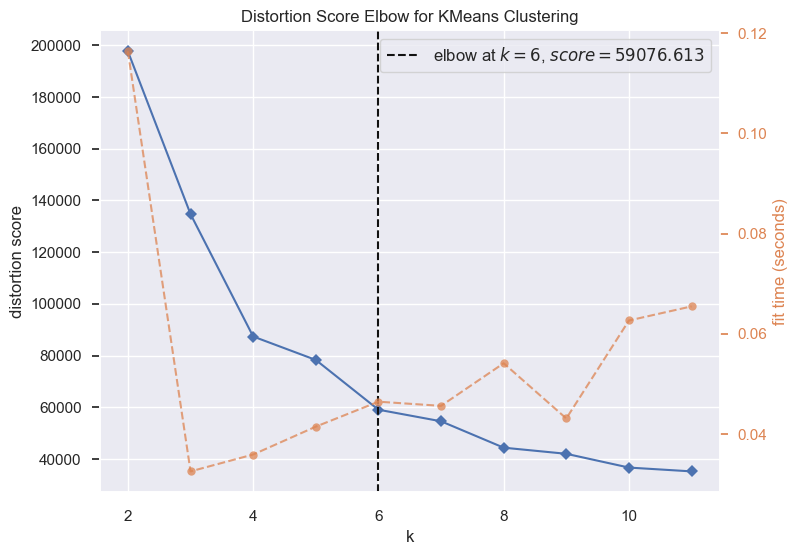

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [10]:
plt.rcParams['figure.figsize'] = (8, 6)

Par défaut, la métrique utilisée est `distorsion`, qui calcule la somme des carrés des distances entre chaque point et son cluster. On peut utiliser d'autres métriques, comme celle de `calinski_harabasz`.

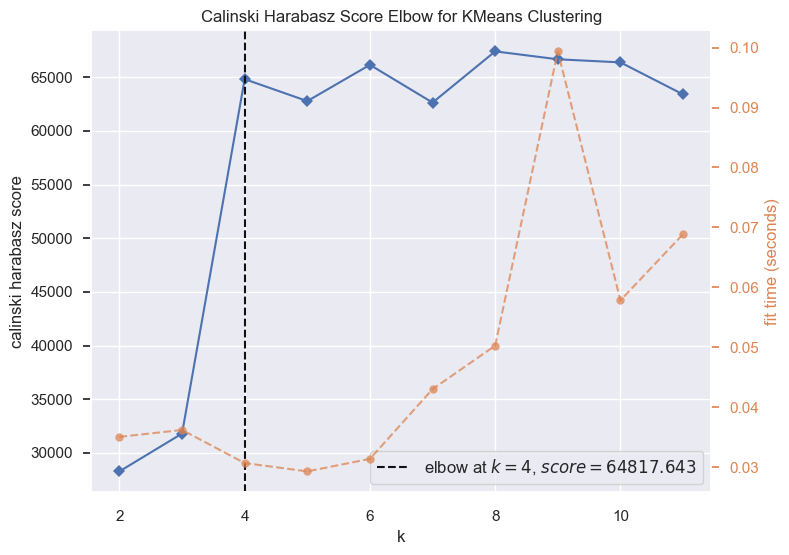

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [11]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Pour savoir si un point x appartient au bon cluster on peut mesurer son coefficient de silhouette.
Il est compris entre -1 et 1, et d'autant plus proche de 1 que l'assignation de x à son cluster est satisfaisante. Pour évaluer un clustering, on peut calculer son coefficient de silhouette moyen.

In [12]:
# On prend un échantillon des données pour que le temps de calcul soit plus court
X_rfm_sample = X_rfm.sample(10000, random_state=1)
X_rfm_scaled_sample = scaler.transform(X_rfm_sample)
# On remet sous forme de DataFrame
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, index=X_rfm_sample.index, 
                                   columns=X_rfm_sample.columns)

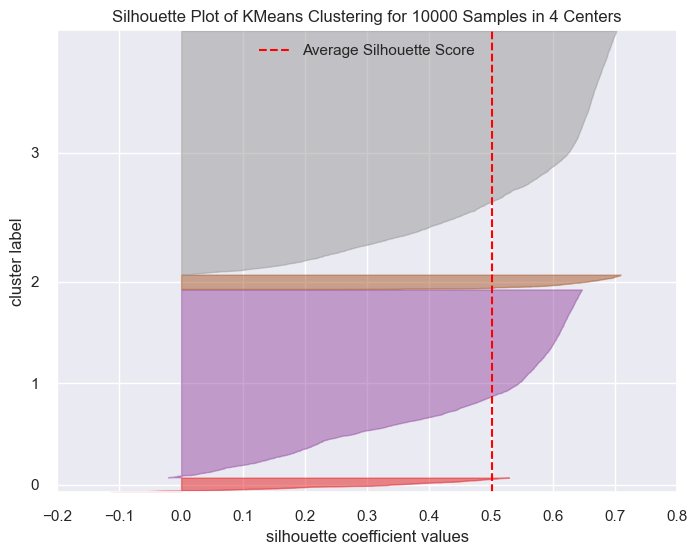

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
n_clust = 4
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=5)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfm_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Les clusters 0 et 1 sont beaucoup plus larges que les autres, ce qui signifie qu'ils contiennent plus de points. On peut voir aussi que le coefficient de silhouette est négatif pour certains points, ce qui signifie qu'ils ont été attribués au mauvais cluster. La ligne en pointillé indique la valeur moyenne du coefficient de silhouette.

On peut calculer directement le coefficient de silhouette moyen avec `sklearn.metrics.silhouette_score`

In [14]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfm_scaled_sample, labels, metric='euclidean')

np.float64(0.5010023255571486)

### Clustering

In [15]:
# Clustering par K-means
kmeans = KMeans(n_clusters=n_clust, random_state=5)
kmeans.fit(X_rfm_scaled)

# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

In [16]:
# Nombre de clients par cluster
pd.Series(clusters).value_counts()

1    50719
0    37808
3     2479
2      214
Name: count, dtype: int64

### Visualisations

#### Visualisation sur les plans factoriels

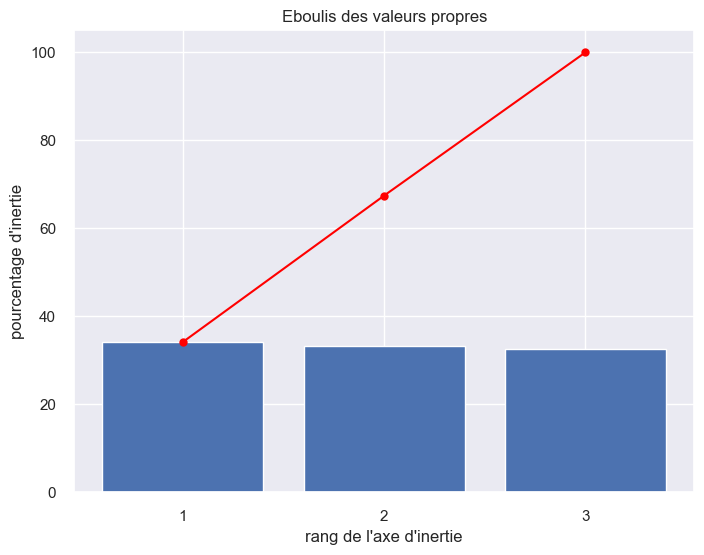

In [17]:
# ACP
n_comp = 3 #nombre de composantes
pca = decomposition.PCA(n_components=n_comp).fit(X_rfm_scaled)
X_rfm_projected = pca.transform(X_rfm_scaled)

# Scree plot
display_scree_plot(pca)

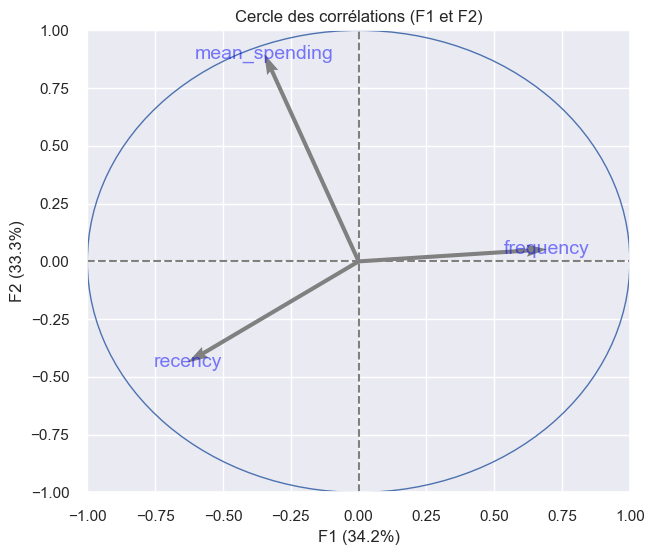

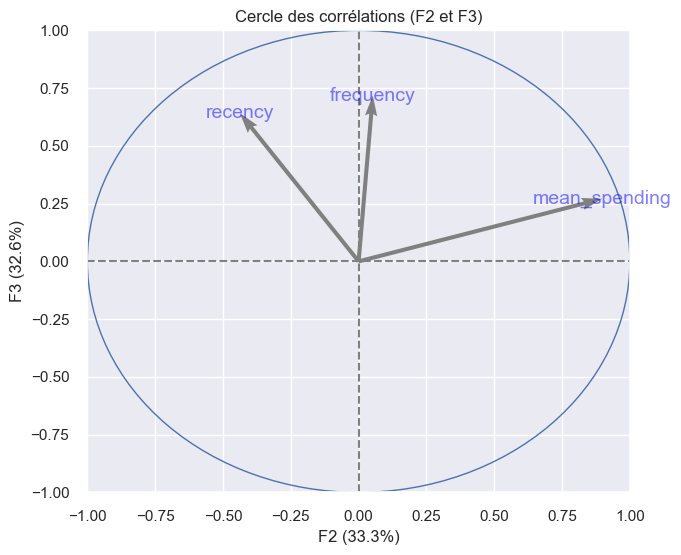

In [18]:
# Cercle des corrélations
pcs = pca.components_
axis_ranks = [(0,1), (1,2)]
labels = X_rfm.columns
display_circles(pcs, n_comp, pca, axis_ranks, labels=labels)

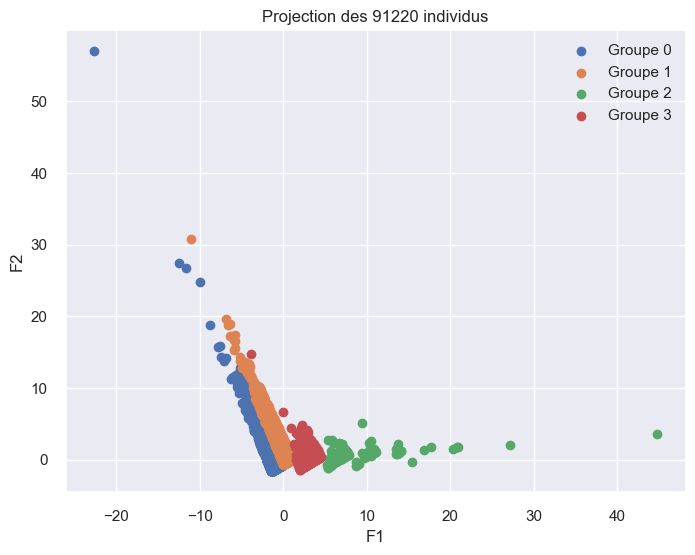

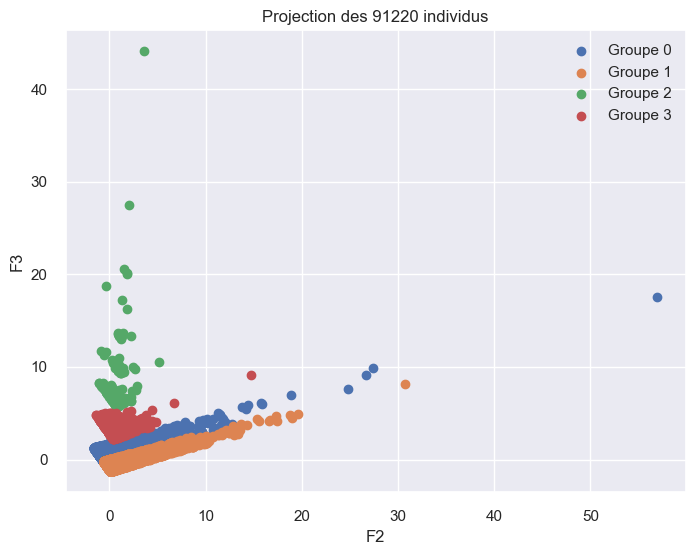

In [19]:
# Affichage du clustering par projection des individus sur les plans factoriels
for (i,j) in axis_ranks:
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfm_projected[mask, i], X_rfm_projected[mask, j], label='Groupe {}'.format(cluster))
    plt.title('Projection des {} individus'.format(X_rfm_projected.shape[0]))
    plt.xlabel('F{}'.format(i+1))
    plt.ylabel('F{}'.format(j+1))
    plt.legend();

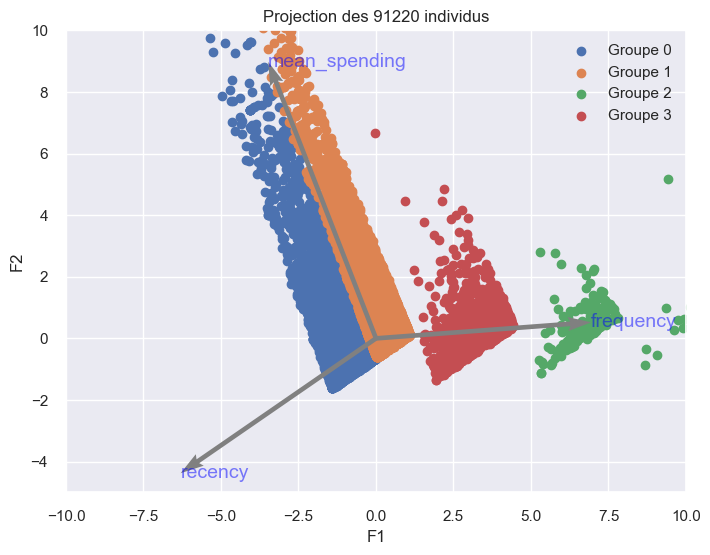

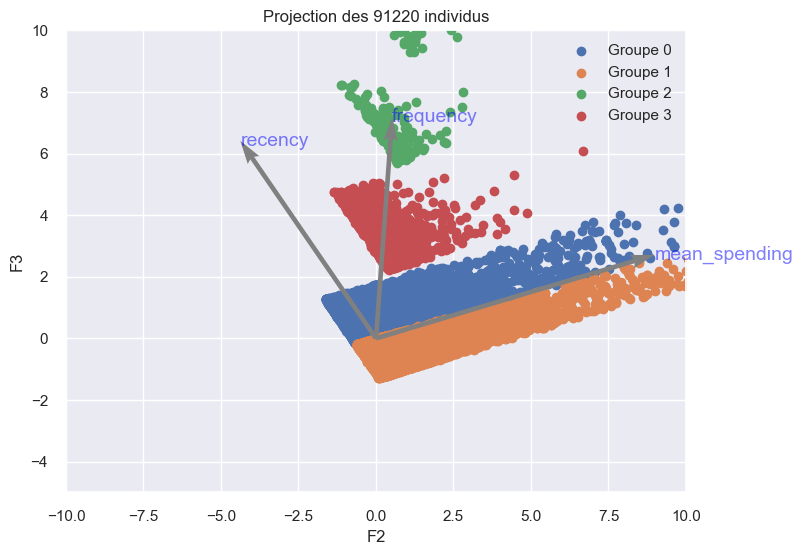

In [20]:
# Affichage du clustering par projection des individus sur les plans factoriels et de la projection
# des variables mises à léchelle selon les limites du graphe
for (i,j) in axis_ranks:
    fig, ax = plt.subplots()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        ax.scatter(X_rfm_projected[mask, i], X_rfm_projected[mask, j], label='Groupe {}'.format(cluster))
        
    # Flèches
    xmax = 10 #ax.get_xlim()[1]
    xmin = -10
    ymax = 10 #ax.get_ylim()[1]
    ymin = -5
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
    pcs[i,:]*xmax, pcs[j,:]*ymax, 
    angles='xy', scale_units='xy', scale=1, color="grey")
    
    # affichage des noms des variables  
    if labels is not None:  
        for l,(x, y) in enumerate(pcs[[i,j]].T):
            if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                plt.text(x*xmax, y*ymax, labels[l], fontsize='14', ha='left', va='center', 
                         color="blue", alpha=0.5)
    
    plt.title('Projection des {} individus'.format(X_rfm_projected.shape[0]))
    plt.xlabel('F{}'.format(i+1))
    plt.ylabel('F{}'.format(j+1))
    plt.legend();

Visualisation 3D

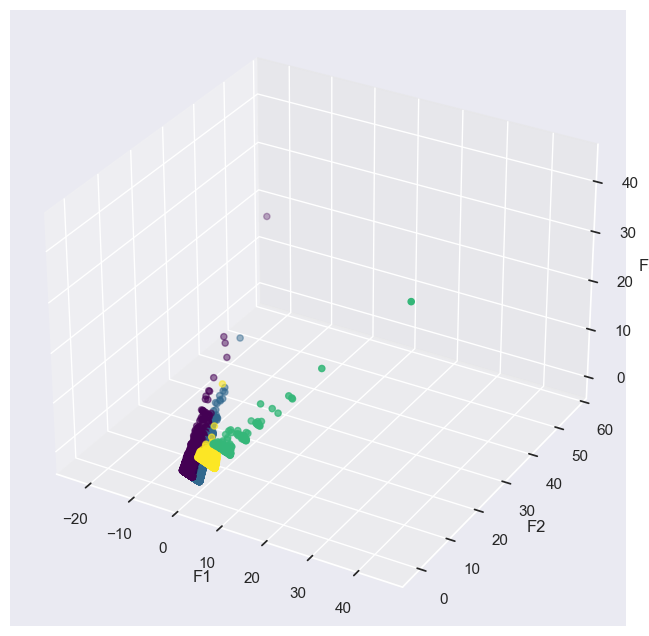

In [21]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
x = X_rfm_projected[:, 0]
y = X_rfm_projected[:, 1]
z = X_rfm_projected[:, 2]
ax.scatter(x, y, z, c=clusters, cmap='viridis')
ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('F3');

#### Visualisation dans l'espace des variables

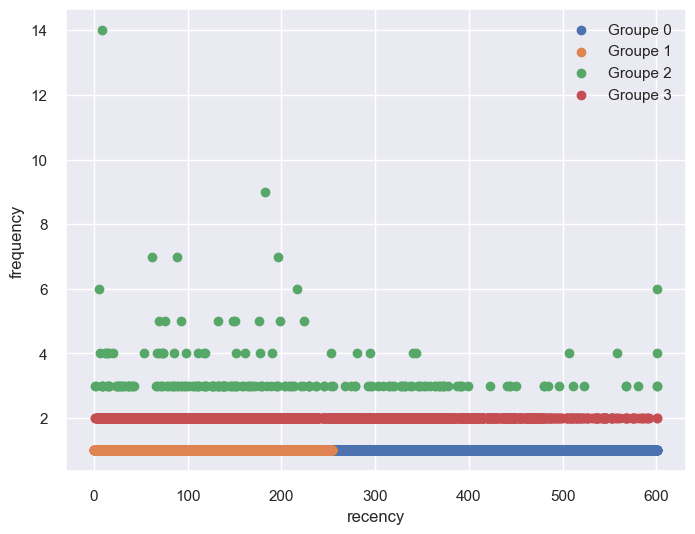

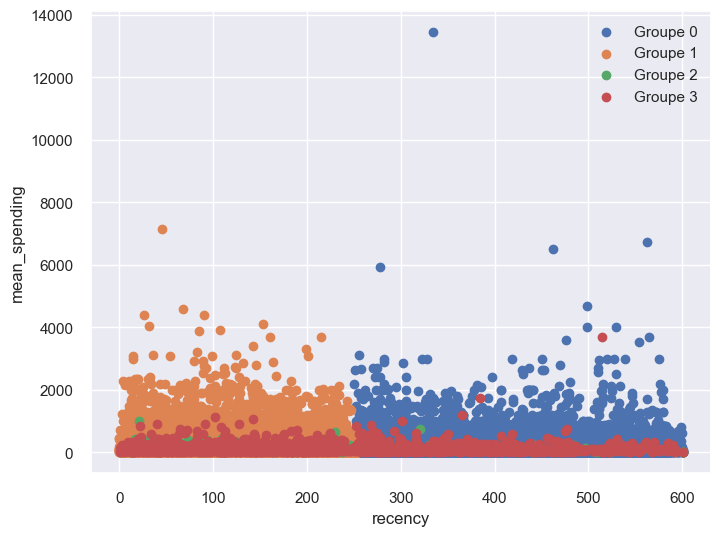

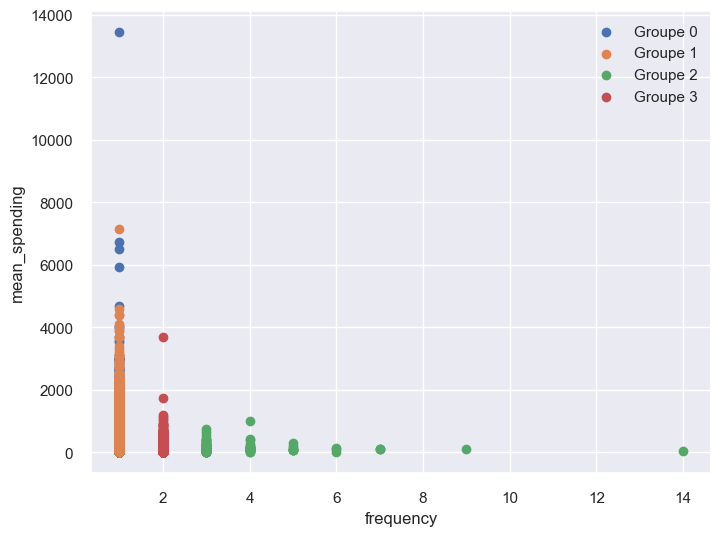

In [22]:
for (i, j) in ((0,1), (0,2), (1,2)):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfm.iloc[mask, i], X_rfm.iloc[mask, j], label='Groupe {}'.format(cluster))
    plt.xlabel(X_rfm.columns[i])
    plt.ylabel(X_rfm.columns[j])
    plt.legend();

#### Box plots

In [23]:
df_rfm['cluster'] = clusters

On va tracer les boxplots des différentes variables en fonction des clusters

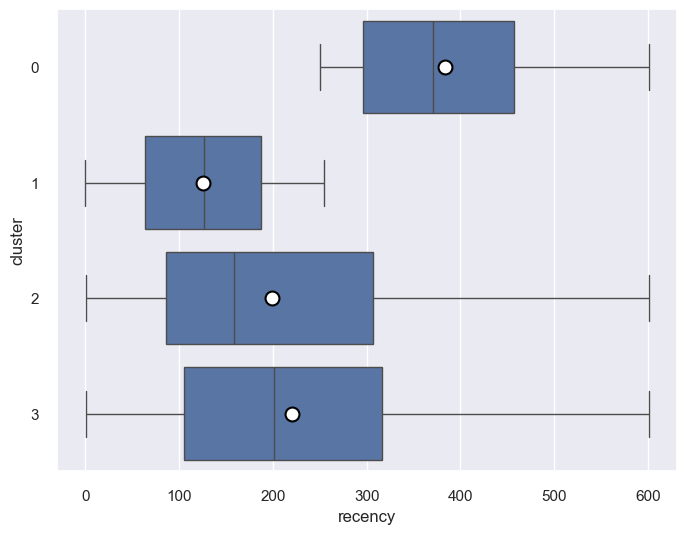

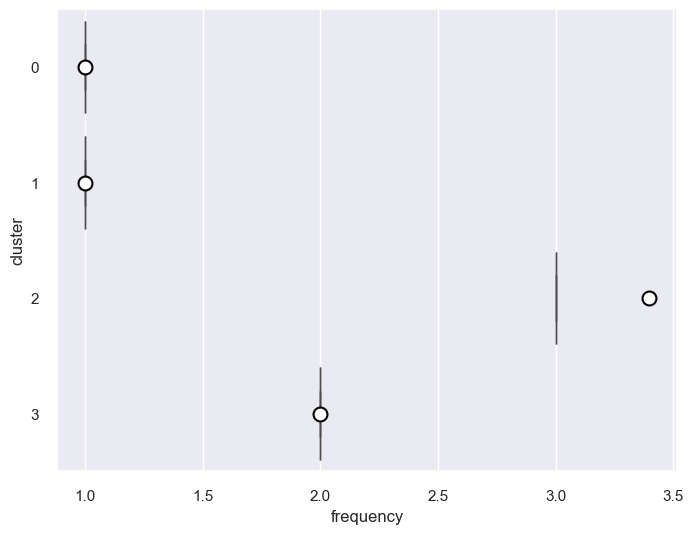

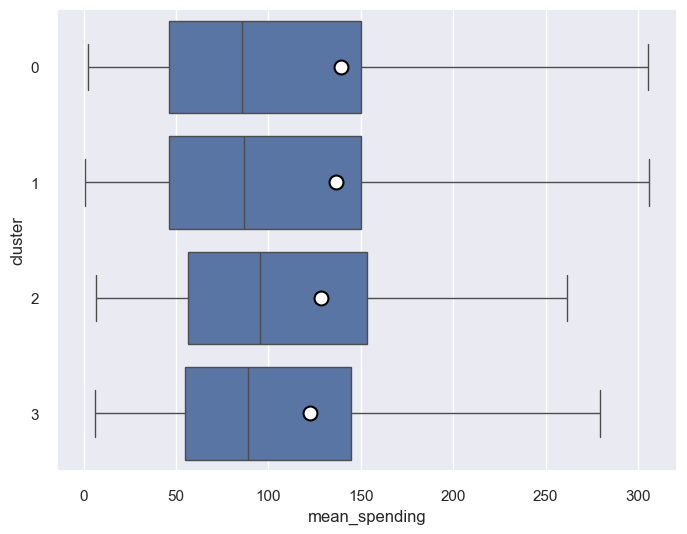

In [24]:
for col in df_rfm.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfm, orient='h', showfliers=False, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

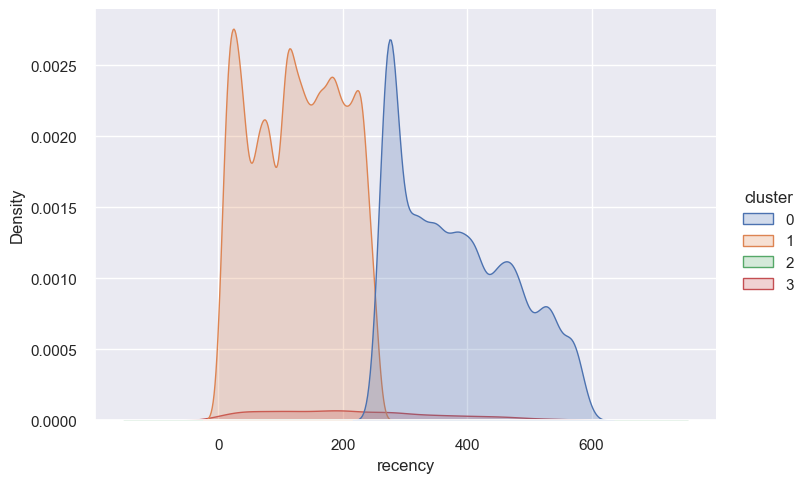

In [25]:
sns.displot(x='recency', data=df_rfm, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

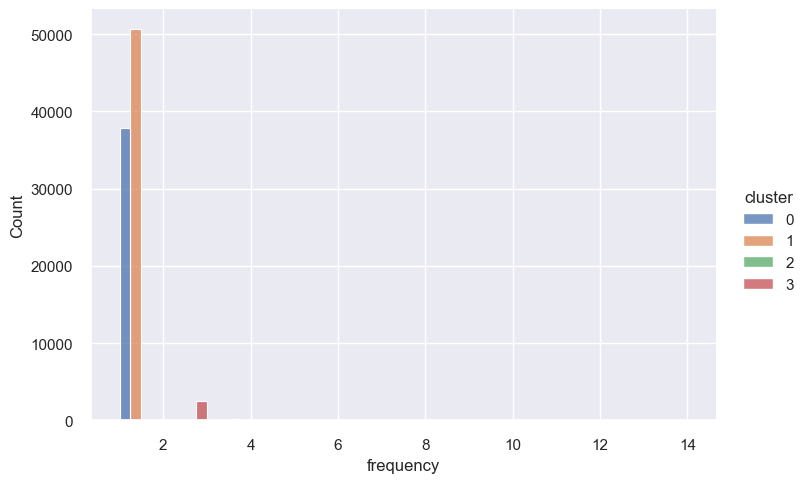

In [155]:
sns.displot(x='frequency', data=df_rfm, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

In [158]:
pd.crosstab(df_rfm['frequency'], df_rfm['cluster'])

cluster        0      1    2     3
frequency                         
1          37808  50719    0     0
2              0      0    0  2479
3              0      0  168     0
4              0      0   29     0
5              0      0    9     0
6              0      0    3     0
7              0      0    3     0
9              0      0    1     0
14             0      0    1     0

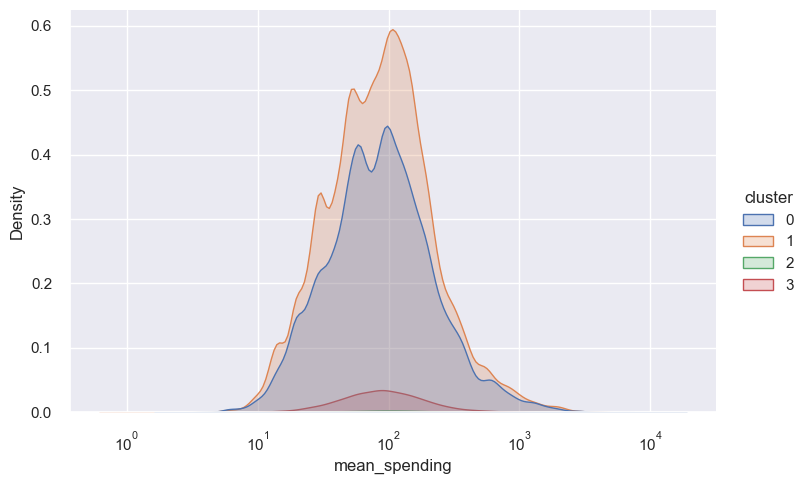

In [27]:
sns.displot(x='mean_spending', data=df_rfm, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5,
           log_scale=True);

On peut en conclure que :
- Le cluster 0 représente les clients récents (< 250 jours)
- Le cluster 1 représente les clients anciens (> 250 jours)
- Le cluster 2 représente les clients qui ont effectués plusieurs commandes
- Le cluster 3 représente les clients qui dépensent beaucoup (environ 1000 en moyenne)

## DBSCAN

On va maintenant essayer de faire le clustering avec l'algorithme `DBSCAN`

In [28]:
from sklearn.cluster import DBSCAN

In [29]:
X_rfm_sample = X_rfm.sample(20000, random_state=1)
scaler = StandardScaler()
X_rfm_scaled_sample = scaler.fit_transform(X_rfm_sample)
# On remet sous forme de DataFrame
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, 
                                   index=X_rfm_sample.index, columns=X_rfm_sample.columns)

In [30]:
db = DBSCAN(eps=1, min_samples=5)
db.fit(X_rfm_scaled_sample)
pd.Series(db.labels_).value_counts()

 0    19409
 1      524
 2       39
-1       20
 3        8
Name: count, dtype: int64

Après plusieurs essais avec des valeurs différentes pour les paramètres `eps` et `min_sample` je n'ai pas obtenu de résultats satisfaisants. Soit la plupart des clusters sont trop peu peuplés, soit il y a trop de bruit (valeur -1).

## Clustering hiérarchique

On va maintenant utiliser un clustering hiérarchique avec l'algorithme `AgglomerativeClustering`

In [31]:
from sklearn.cluster import AgglomerativeClustering

Comme le clustering hiérarchique est plus lent que le kmeans, on va faire le clustering sur un échantillon des data

In [32]:
X_rfm_sample = X_rfm.sample(10000, random_state=1)
X_rfm_scaled_sample = scaler.transform(X_rfm_sample)
# On remet sous forme de DataFrame
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, 
                                   index=X_rfm_sample.index, columns=X_rfm_sample.columns)

In [33]:
agglo = AgglomerativeClustering(n_clusters=n_clust, linkage='ward')
agglo.fit(X_rfm_scaled_sample)
clusters = agglo.labels_

In [34]:
# Nombre de clients par cluster si on avait le même nombre de clients que dans X_rfm
(pd.Series(clusters).value_counts(normalize=True) * X_rfm.shape[0]).astype('int')

0    64127
3    20643
2     3603
1     2846
Name: proportion, dtype: int64

### Visualisations

#### Visualisation sur les plans factoriels

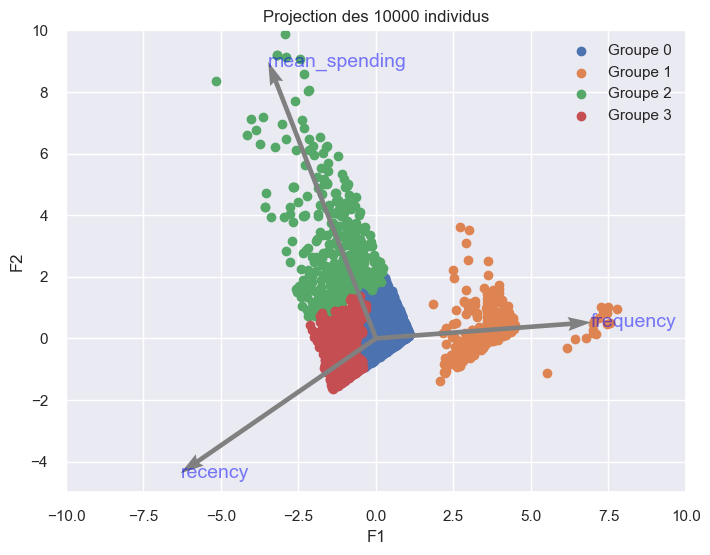

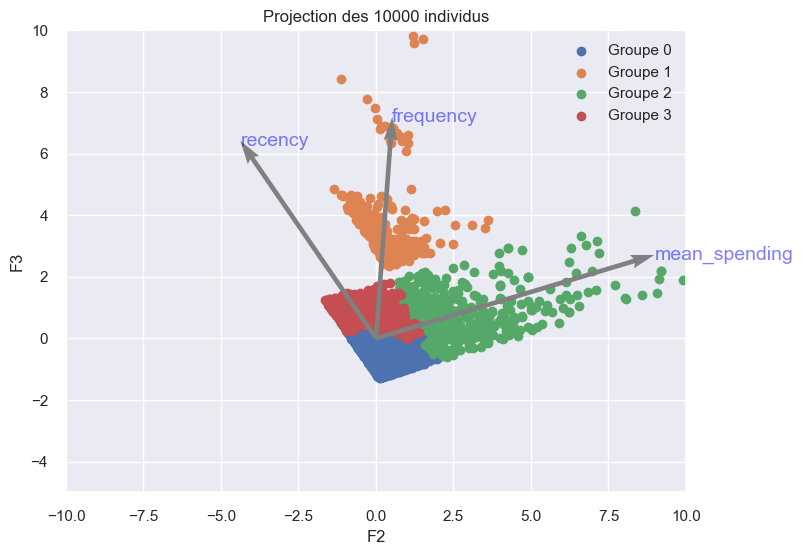

In [35]:
# Affichage du clustering par projection des individus sur les plans factoriels et de la projection
# des variables mises à léchelle selon les limites du graphe

X_rfm_projected = pca.transform(X_rfm_scaled_sample)

for (i,j) in axis_ranks:
    fig, ax = plt.subplots()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        ax.scatter(X_rfm_projected[mask, i], X_rfm_projected[mask, j], label='Groupe {}'.format(cluster))
        
    # Flèches
    xmax = 10 #ax.get_xlim()[1]
    xmin = - 10
    ymax = 10 #ax.get_ylim()[1]
    ymin = - 5
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
    pcs[i,:]*xmax, pcs[j,:]*ymax, 
    angles='xy', scale_units='xy', scale=1, color="grey")
    
    # affichage des noms des variables  
    if labels is not None:  
        for l,(x, y) in enumerate(pcs[[i,j]].T):
            if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                plt.text(x*xmax, y*ymax, labels[l], fontsize='14', ha='left', va='center', 
                         color="blue", alpha=0.5)
    
    plt.title('Projection des {} individus'.format(X_rfm_projected.shape[0]))
    plt.xlabel('F{}'.format(i+1))
    plt.ylabel('F{}'.format(j+1))
    plt.legend();

#### Visualisation dans l'espace des variables

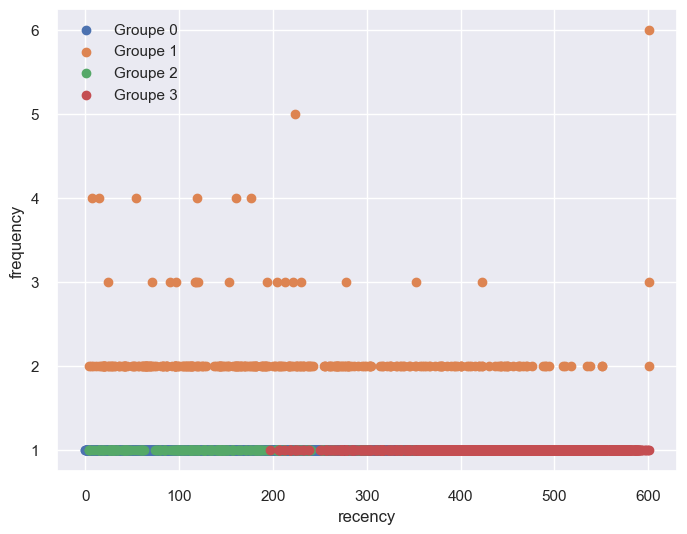

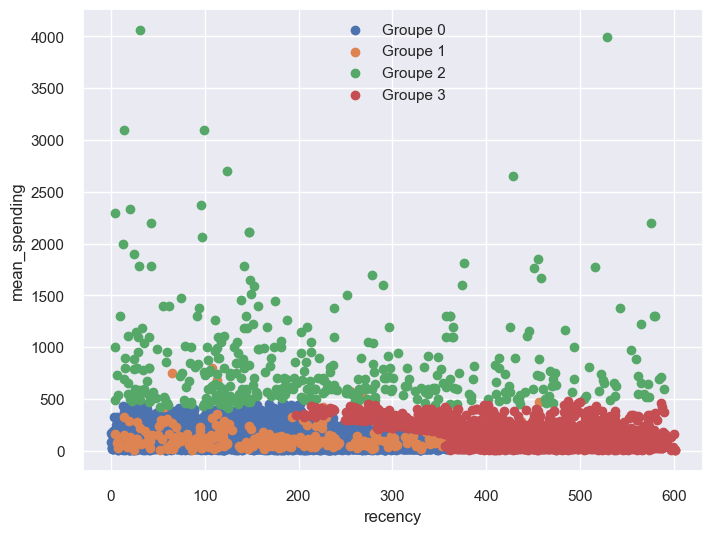

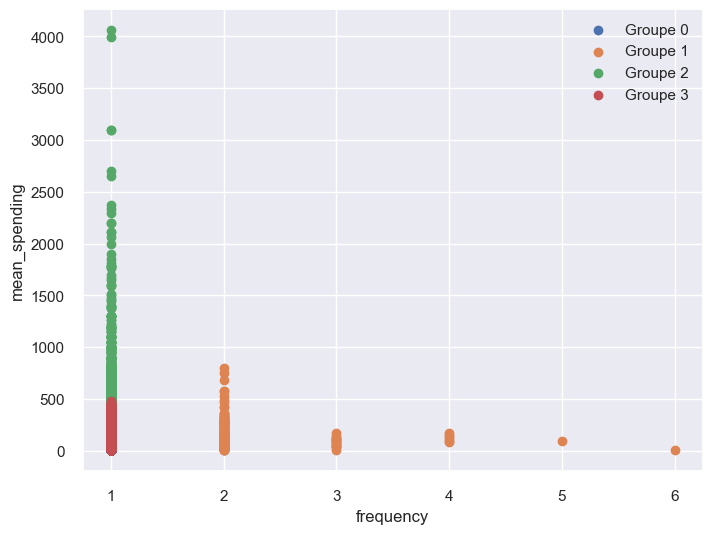

In [36]:
for (i, j) in ((0,1), (0,2), (1,2)):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfm_sample.iloc[mask, i], X_rfm_sample.iloc[mask, j], label='Groupe {}'.format(cluster))
    #plt.xticks(rotation=30)
    plt.xlabel(X_rfm.columns[i])
    plt.ylabel(X_rfm.columns[j])
    plt.legend();

In [37]:
X_rfm_sample['cluster'] = clusters

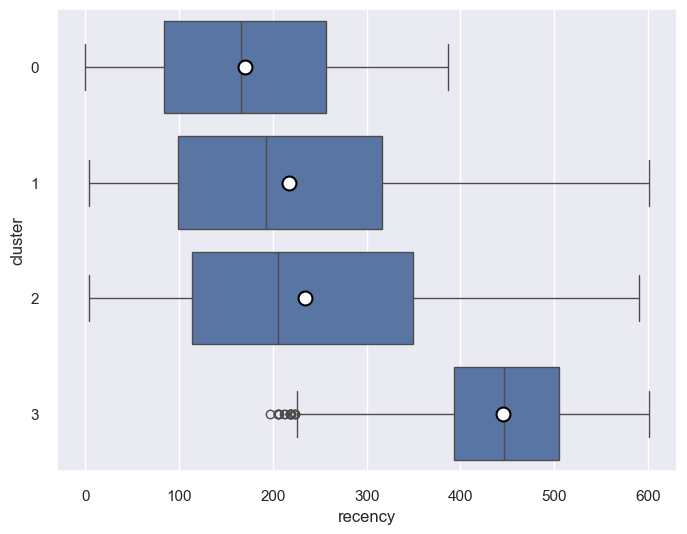

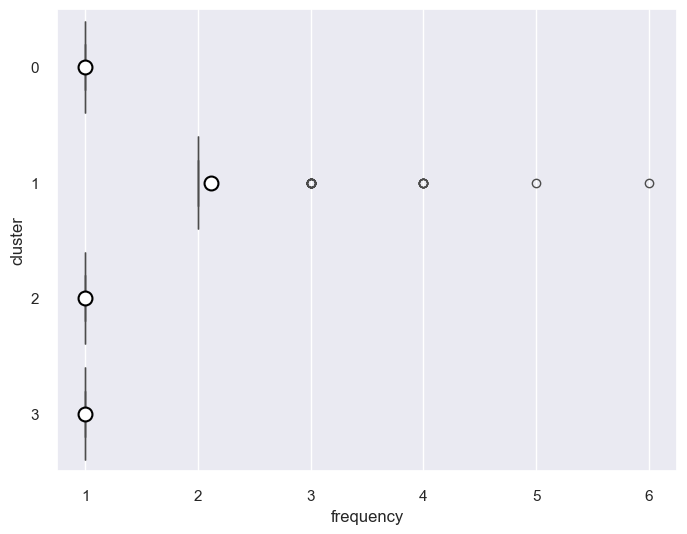

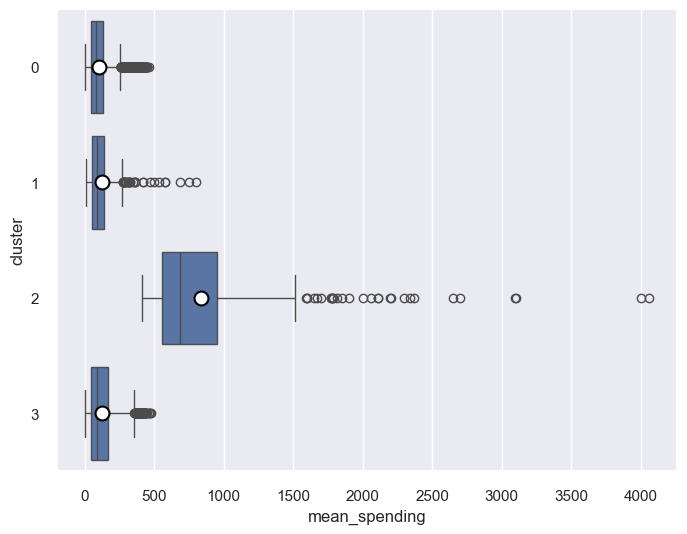

In [38]:
for col in df_rfm.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=X_rfm_sample, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

On obtient des résultats similaires au KMeans avec un cluster pour les clients récents, les clients anciens, les clients fréquents et ceux qui dépensent beaucoup

## Comparaison

In [39]:
from time import time

In [40]:
print(42 * "_")
print("model\t\ttime\tsilhouette")

#KMeans
t0 = time()
kmeans.fit(X_rfm_scaled_sample)
fit_time = time() - t0
results = ['kmeans', fit_time, silhouette_score(X_rfm_scaled_sample, kmeans.labels_, metric='euclidean')]
formatter_result = (
    "{:9s}\t{:.3f}s\t{:.3f}"
)
print(formatter_result.format(*results))

#AgglomerativeClustering
t0 = time()
agglo.fit(X_rfm_scaled_sample)
fit_time = time() - t0
results = ['agglo', fit_time, silhouette_score(X_rfm_scaled_sample, agglo.labels_, metric='euclidean')]
formatter_result = (
    "{:9s}\t{:.3f}s\t{:.3f}"
)
print(formatter_result.format(*results))

__________________________________________
model		time	silhouette
kmeans   	0.010s	0.496
agglo    	2.900s	0.473


On voit que les coefficients de silhouette sont similaires mais que le `KMeans` est beaucoup plus rapide que l'`AggloAgglomerativeClustering`. On va donc se concentrer sur le `KMeans` pour la suite

## Réduction dimensionnelle linéaire

On va essayer d'autres algorithmes de réduction dimensionnelle linéaire que l'ACP pour voir si on peut mieux visualiser les clusters dans un espace 2D

### Factor Analysis

In [41]:
from sklearn.decomposition import FactorAnalysis

In [42]:
fa = FactorAnalysis(n_components=2)
X_rfm_fa = fa.fit_transform(X_rfm_scaled)

In [43]:
# Clustering par K-means
kmeans.fit(X_rfm_scaled)

# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

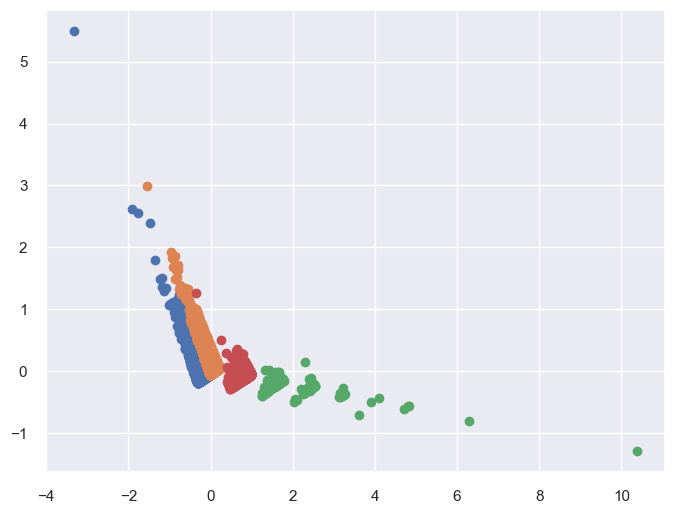

In [44]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_fa[mask,0], X_rfm_fa[mask,1])

Résultats similaires à l'ACP

### Non-Negative Matrix Factorization

In [45]:
from sklearn.decomposition import NMF

In [46]:
nmf = NMF(n_components=2, max_iter=400)
# Normalisation MinMax pour garder des valeurs positives
X_rfm_minmax = MinMaxScaler().fit_transform(X_rfm)
X_rfm_nmf = nmf.fit_transform(X_rfm_minmax)

In [47]:
# Clustering par K-means
kmeans.fit(X_rfm_minmax)

# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

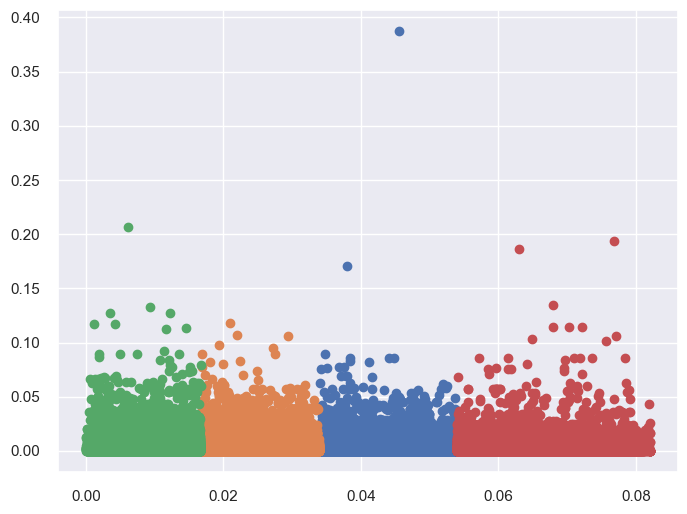

In [48]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_nmf[mask,0], X_rfm_nmf[mask,1])

Les clusters sont bien distincts mais collés les uns aux autres

## Réduction dimensionnelle non-linéaire

On va essayer différents algorithmes de réduction dimensionnelle non-linéaire pour voir si on peut visualiser les clusters dans un espace 2D

### TSNE

In [49]:
from sklearn.manifold import TSNE

In [50]:
X_rfm_sample = X_rfm.sample(5000, random_state=0)
X_rfm_scaled_sample = scaler.transform(X_rfm_sample)
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, 
                                   index=X_rfm_sample.index, columns=X_rfm_sample.columns)

In [51]:
tsne = TSNE(n_components=2, init='pca')
X_rfm_tsne = tsne.fit_transform(X_rfm_scaled_sample)

$>$ 4min de compilation si on fit sur l'ensemble des données

In [52]:
kmeans.fit(X_rfm_scaled_sample)

# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

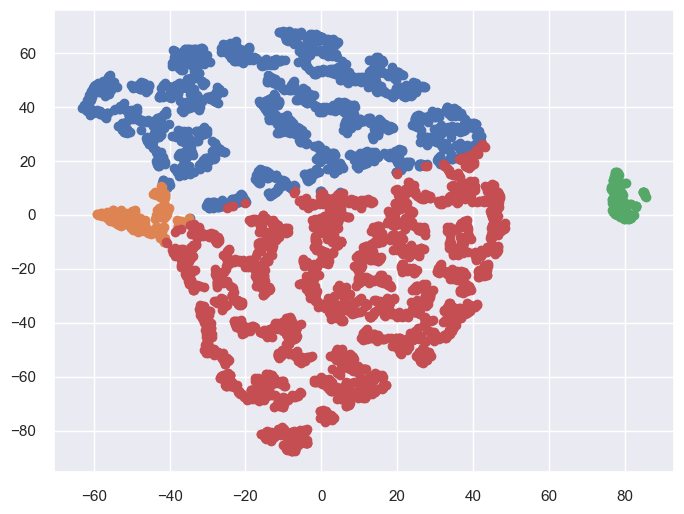

In [53]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_tsne[mask,0], X_rfm_tsne[mask,1])

### Isomap

In [54]:
from sklearn.manifold import Isomap

In [55]:
isomap = Isomap(n_components=2, n_neighbors=10)
X_rfm_isomap = isomap.fit_transform(X_rfm_scaled_sample)

/Users/gabriel/Documents/Git/Segment customers of an e-commerce/.venv/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/gabriel/Documents/Git/Segment customers of an e-commerce/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


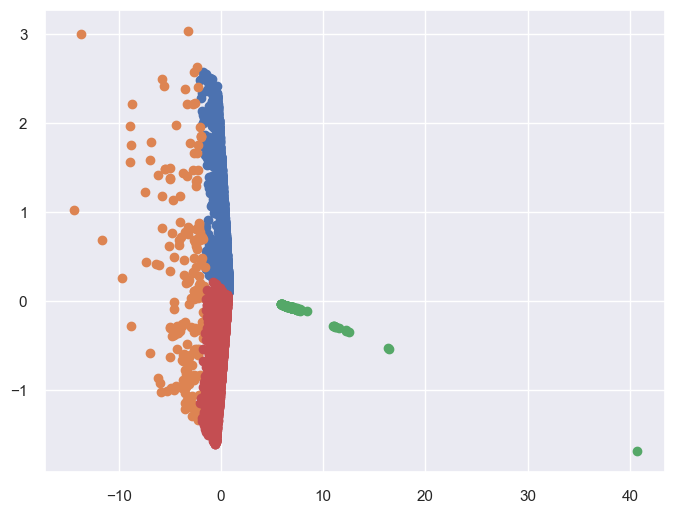

In [56]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_isomap[mask,0], X_rfm_isomap[mask,1])

### LLE

In [57]:
from sklearn.manifold import LocallyLinearEmbedding

In [58]:
lle = LocallyLinearEmbedding(n_components=2, eigen_solver='dense')
X_rfm_lle = lle.fit_transform(X_rfm_scaled_sample)

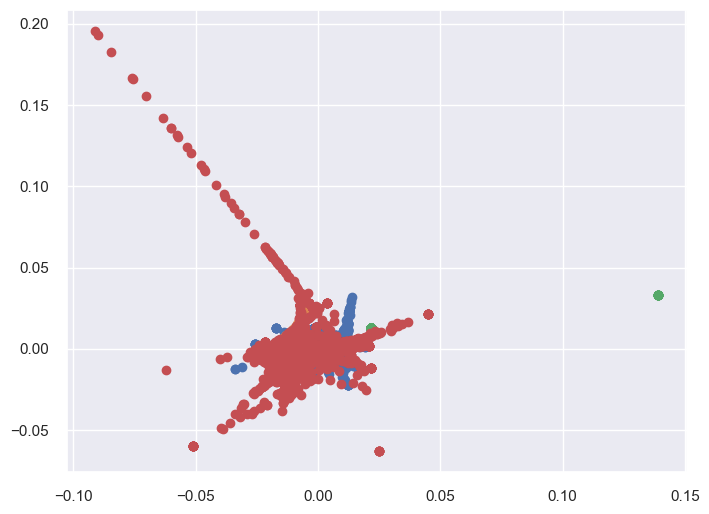

In [59]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_lle[mask,0], X_rfm_lle[mask,1])

### MDS

Le temps de calcul était extrêmement long même avec un échantillon de 5000 individus

### Spectral Embedding

In [60]:
from sklearn.manifold import SpectralEmbedding

In [61]:
spe = SpectralEmbedding(n_components=2)
X_rfm_spe = spe.fit_transform(X_rfm_scaled_sample)

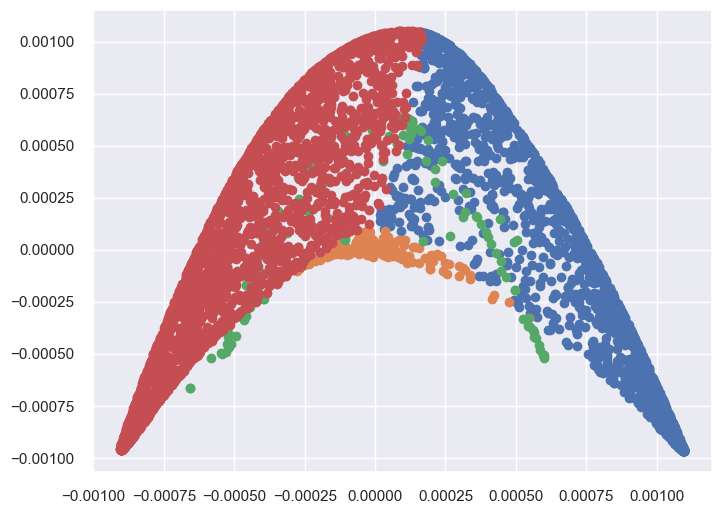

In [62]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_spe[mask,0], X_rfm_spe[mask,1])

Les résultats ne sont pas satisfaisants et les temps de calcul sont très longs

# Segmentation RFMS

On a une colonne en plus à savoir le review Score

In [63]:
df_rfms = pd.read_csv('df_rfms.csv', index_col=0)
df_rfms.head()

recency  frequency  mean_spending  \
customer_unique_id                                                    
4b3207464f5f7a48a7f63fa0b1251d86      601          1            9.9   
527cd2850ef91088969ffbef0103dec3      601          1           11.9   
29a63a400c3ca9982907ce8de1f19527      601          1           10.9   
b6b2c3c8fd76769b478618a3c2505009      601          1           10.9   
f7be9bec658c62ab6240b44cd26c0b84      601          2           10.4   

                                  review_score  
customer_unique_id                              
4b3207464f5f7a48a7f63fa0b1251d86           5.0  
527cd2850ef91088969ffbef0103dec3           5.0  
29a63a400c3ca9982907ce8de1f19527           5.0  
b6b2c3c8fd76769b478618a3c2505009           5.0  
f7be9bec658c62ab6240b44cd26c0b84           5.0

## KMeans

In [64]:
from sklearn.cluster import KMeans

In [65]:
# préparation des données pour le clustering
X_rfms = df_rfms.copy()

# Centrage et réduction
scaler = StandardScaler()
X_rfms_scaled = scaler.fit_transform(X_rfms)
# On remet sous forme de DataFrame
X_rfms_scaled = pd.DataFrame(X_rfms_scaled, columns=X_rfms.columns, index=X_rfms.index)

### Analyse avec Yellowbrick

In [66]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

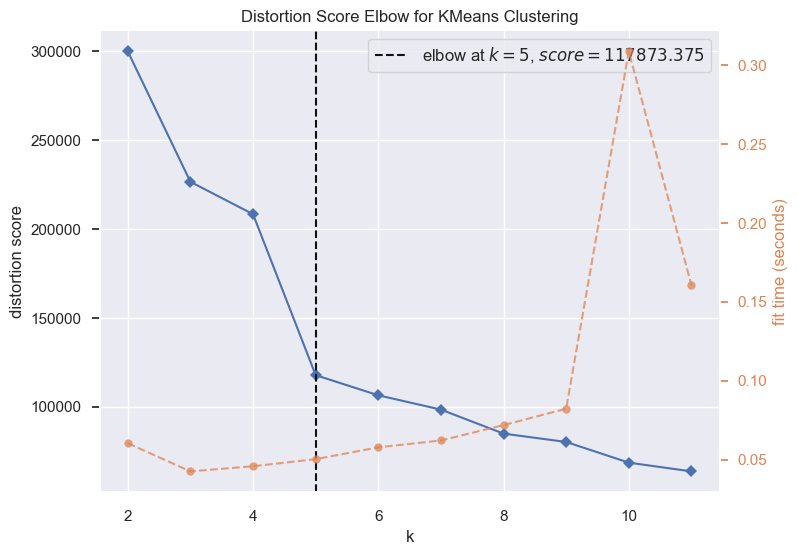

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
plt.rcParams['figure.figsize'] = (8,6)
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfms_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

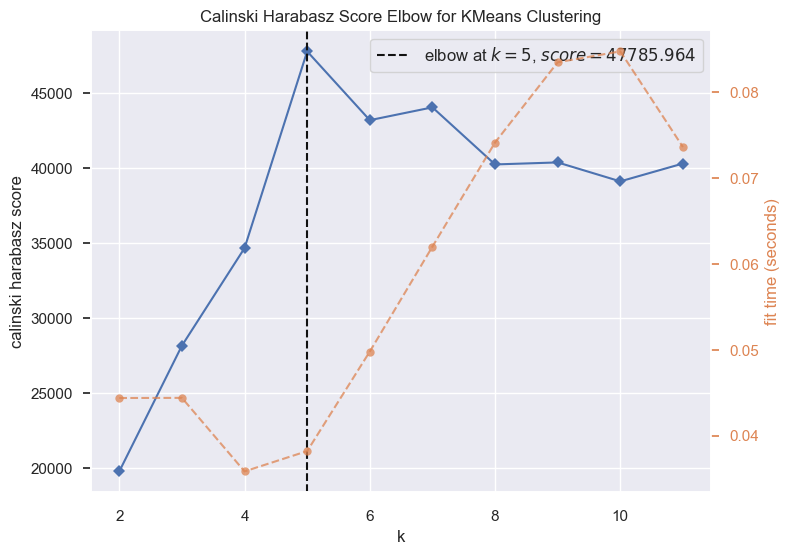

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [68]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfms_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [69]:
X_rfms_sample = X_rfms.sample(10000, random_state=1)
X_rfms_scaled_sample = scaler.transform(X_rfms_sample)
# On remet sous forme de DataFrame
X_rfms_scaled_sample = pd.DataFrame(X_rfms_scaled_sample, 
                                    index=X_rfms_sample.index, columns=X_rfms_sample.columns)

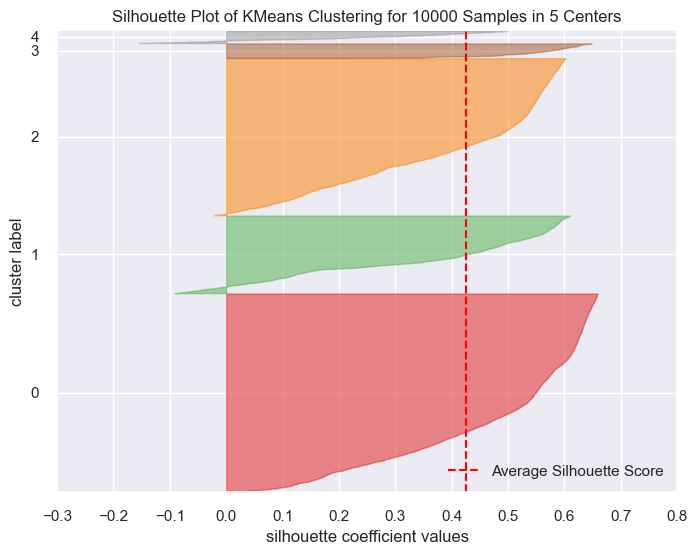

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [70]:
n_clust = 5
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=12)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfms_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Coefficient de silhouette moyen

In [71]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfms_scaled_sample, labels, metric='euclidean')

np.float64(0.4263084905018286)

### Clustering

In [72]:
n_clust = 5

# Clustering par K-means
kmeans = KMeans(n_clusters=n_clust, random_state=12)
kmeans.fit(X_rfms_scaled)

# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3, 4], dtype=int32)

In [73]:
# Nombre de clients par cluster
pd.Series(clusters).value_counts()

2    29543
1    27863
0    19475
4    11646
3     2693
Name: count, dtype: int64

### Visualisations

#### Visualisation sur les plans factoriels

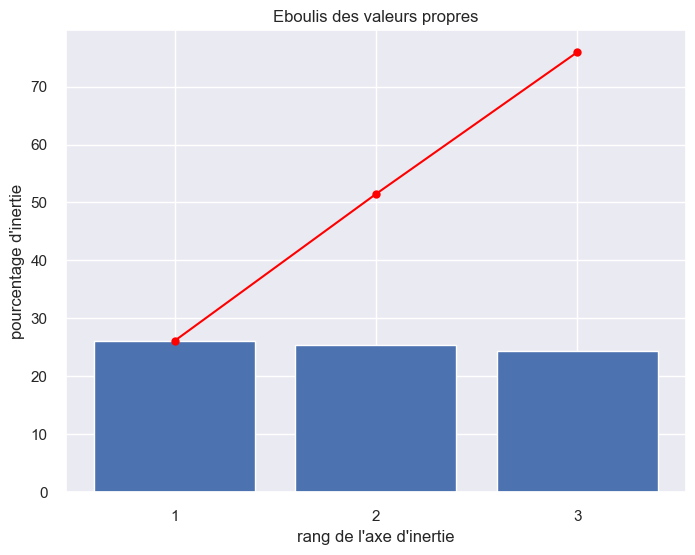

In [74]:
# PCA
n_comp = 3
pca = decomposition.PCA(n_components=n_comp).fit(X_rfms_scaled)
X_rfms_projected = pca.transform(X_rfms_scaled)

# Scree plot
display_scree_plot(pca)

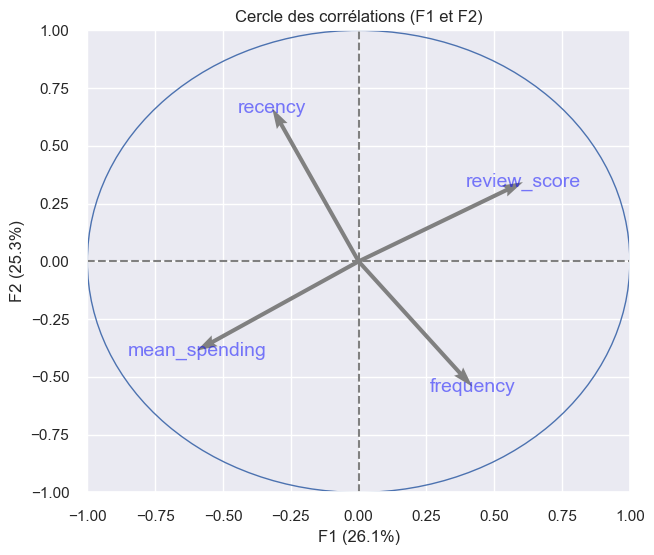

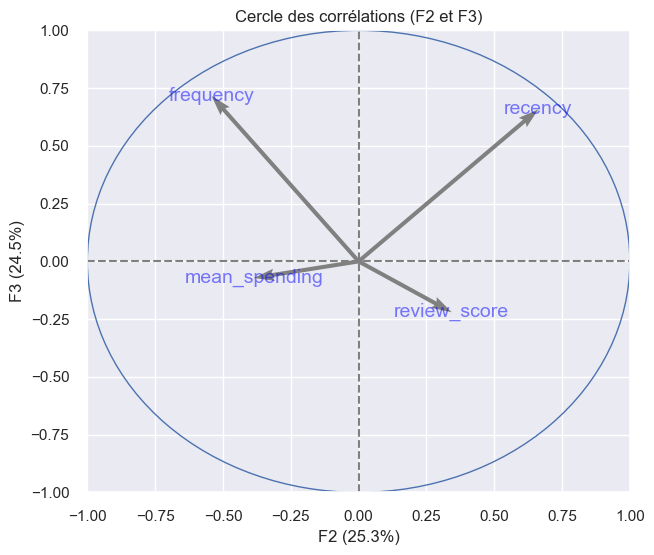

In [75]:
# Cercle des corrélations
pcs = pca.components_
axis_ranks = [(0,1), (1,2)]
labels = X_rfms.columns
display_circles(pcs, n_comp, pca, axis_ranks, labels=labels)

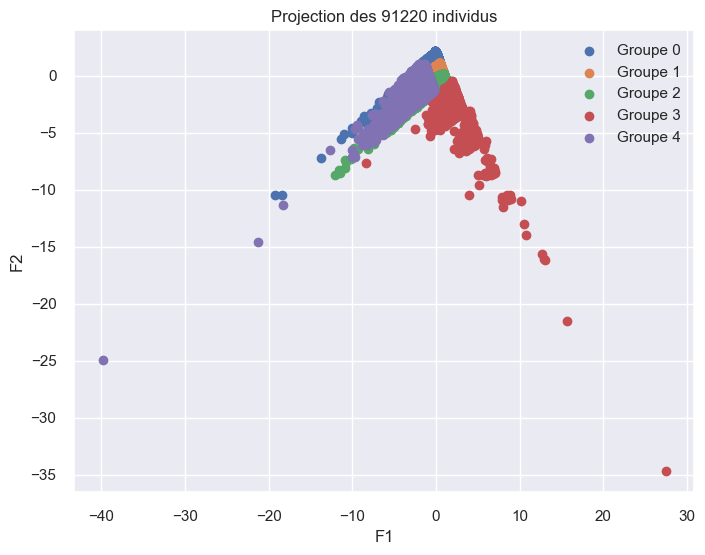

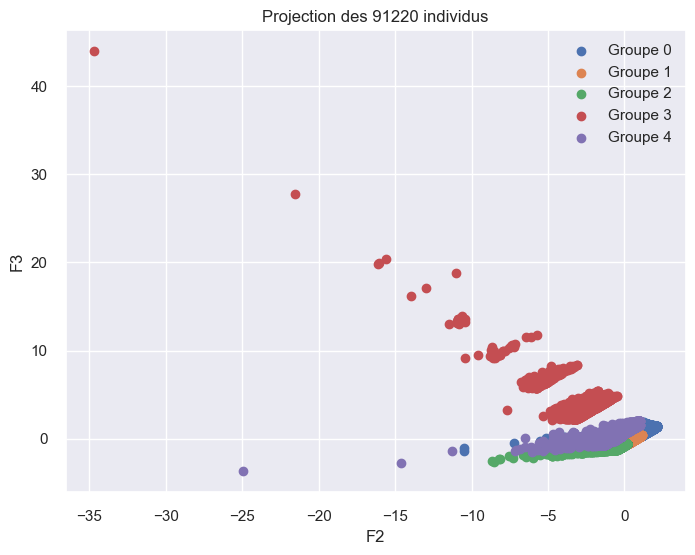

In [76]:
# Affichage du clustering par projection des individus sur les plans factoriels
for (i,j) in axis_ranks:
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfms_projected[mask, i], X_rfms_projected[mask, j], label='Groupe {}'.format(cluster))
    plt.title('Projection des {} individus'.format(X_rfms_projected.shape[0]))
    plt.xlabel('F{}'.format(i+1))
    plt.ylabel('F{}'.format(j+1))
    plt.legend();

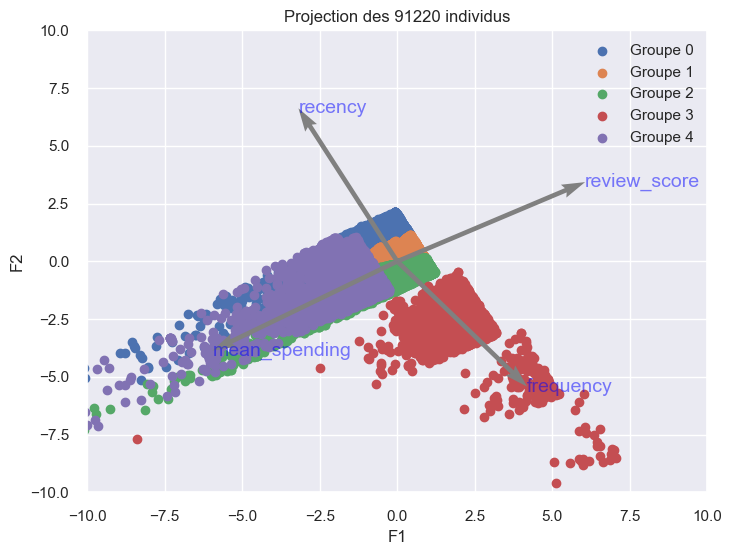

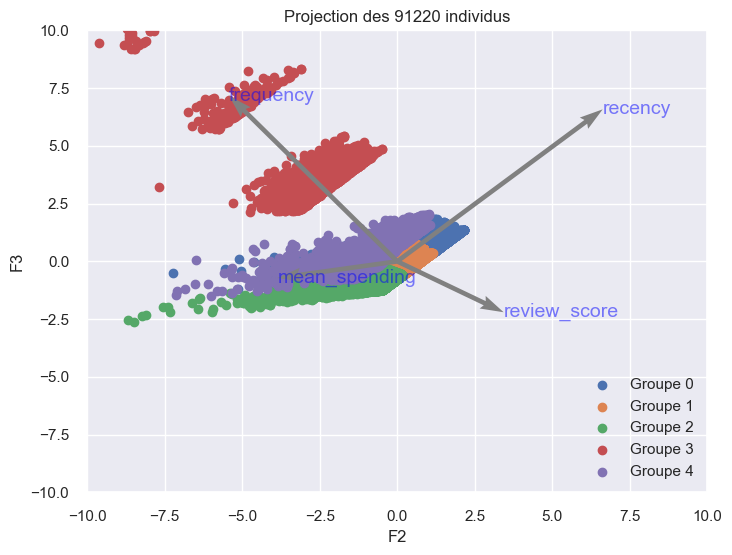

In [77]:
# Affichage du clustering par projection des individus sur les plans factoriels et de la projection
# des variables mises à léchelle selon les limites du graphe
for (i,j) in axis_ranks:
    fig, ax = plt.subplots()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        ax.scatter(X_rfms_projected[mask, i], X_rfms_projected[mask, j], label='Groupe {}'.format(cluster))
        
    # Flèches
    xmax = 10 #ax.get_xlim()[1]
    xmin = -10
    ymax = 10 #ax.get_ylim()[1]
    ymin = -10
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
    pcs[i,:]*xmax, pcs[j,:]*ymax, 
    angles='xy', scale_units='xy', scale=1, color="grey")
    
    # affichage des noms des variables  
    if labels is not None:  
        for l,(x, y) in enumerate(pcs[[i,j]].T):
            if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                plt.text(x*xmax, y*ymax, labels[l], fontsize='14', ha='left', va='center', 
                         color="blue", alpha=0.5)
    
    plt.title('Projection des {} individus'.format(X_rfms_projected.shape[0]))
    plt.xlabel('F{}'.format(i+1))
    plt.ylabel('F{}'.format(j+1))
    plt.legend();

Visualisation 3D

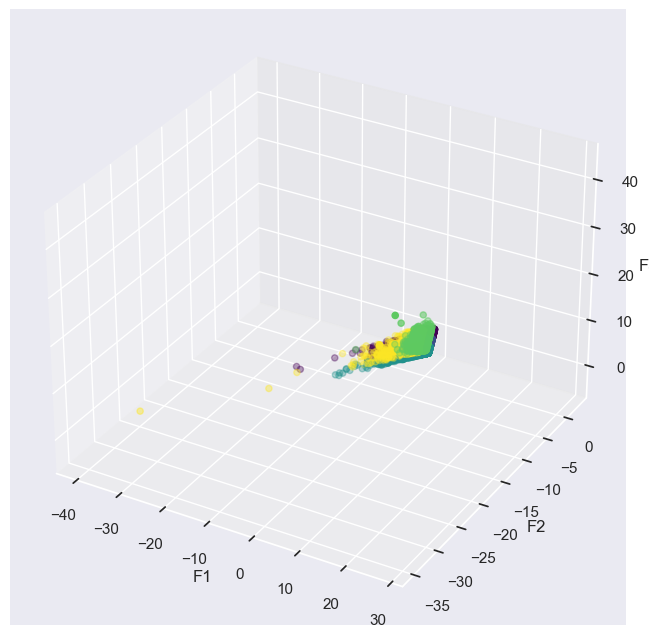

In [78]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
x = X_rfms_projected[:, 0]
y = X_rfms_projected[:, 1]
z = X_rfms_projected[:, 2]
ax.scatter(x, y, z, c=clusters, cmap='viridis')
ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('F3');

#### Visualisation dans l'espace des variables

Pour tracer les graphes 2D, on va utiliser la fonction `combinations` de `itertools` pour être sûr de faire toutes les combinaisons possibles de nos variables

In [79]:
import itertools

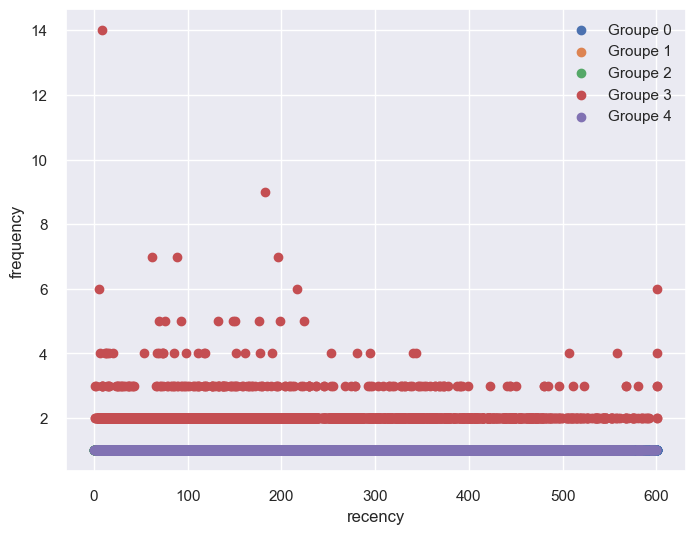

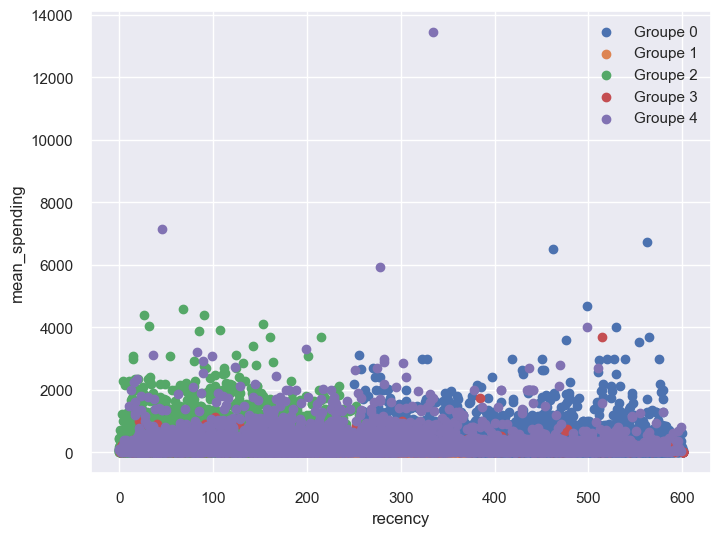

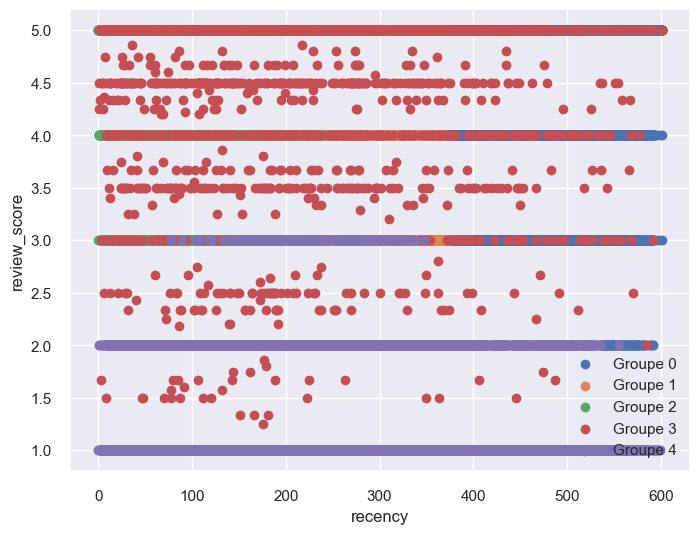

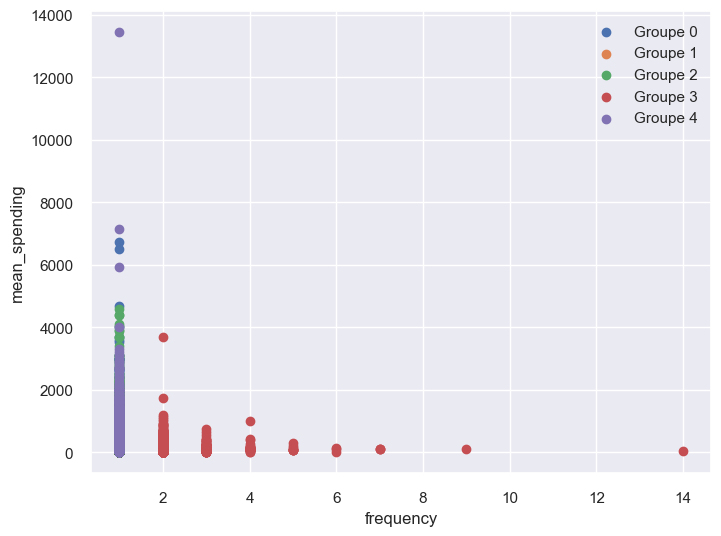

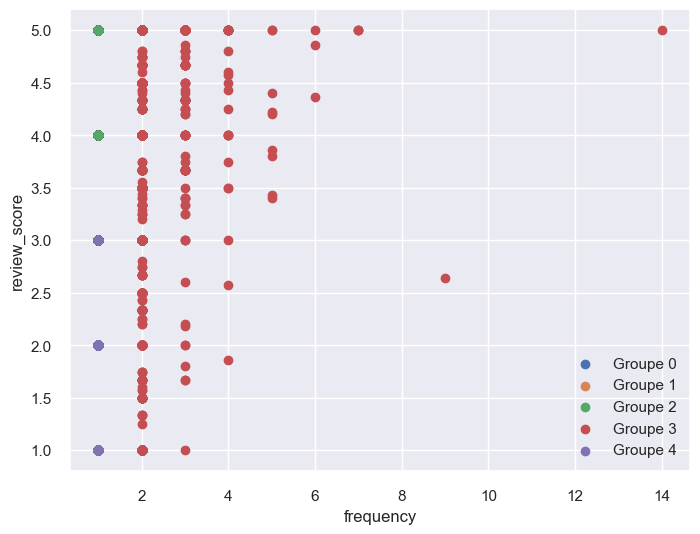

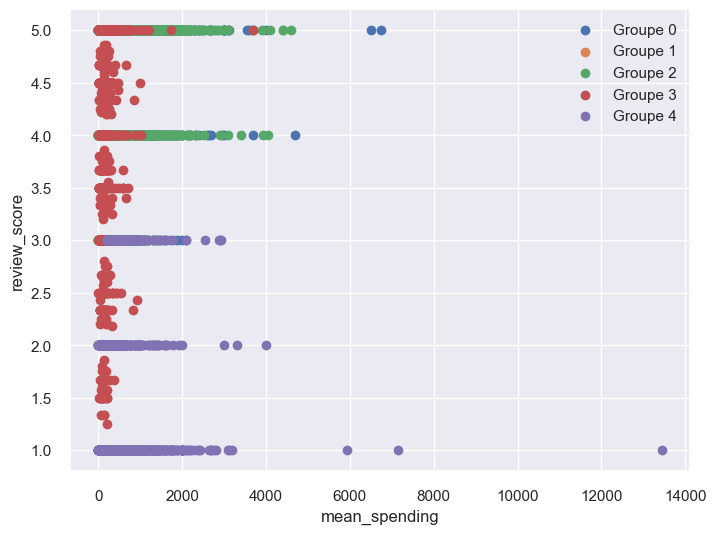

In [80]:
for (i, j) in itertools.combinations(range(X_rfms.shape[1]), 2):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfms.iloc[mask, i], X_rfms.iloc[mask, j], label='Groupe {}'.format(cluster))
    #plt.xticks(rotation=30)
    plt.xlabel(X_rfms.columns[i])
    plt.ylabel(X_rfms.columns[j])
    plt.legend();

#### Box plots

In [81]:
df_rfms['cluster'] = clusters

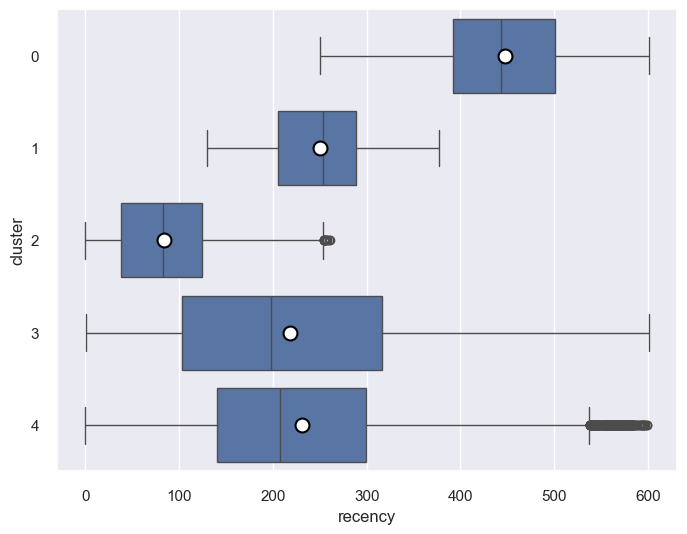

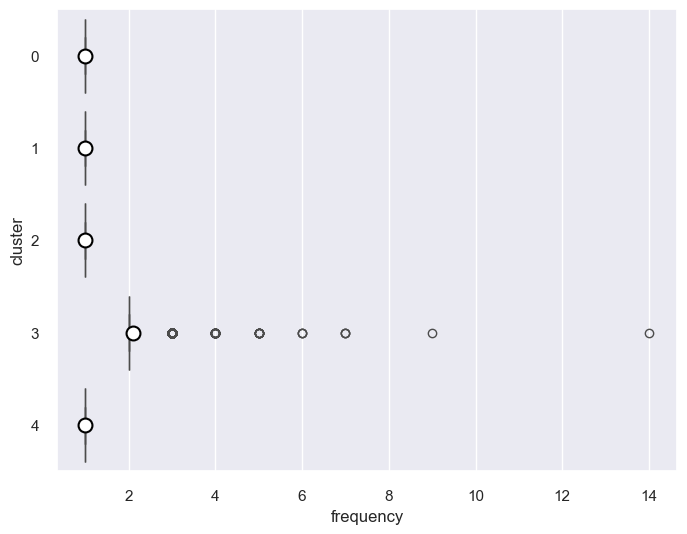

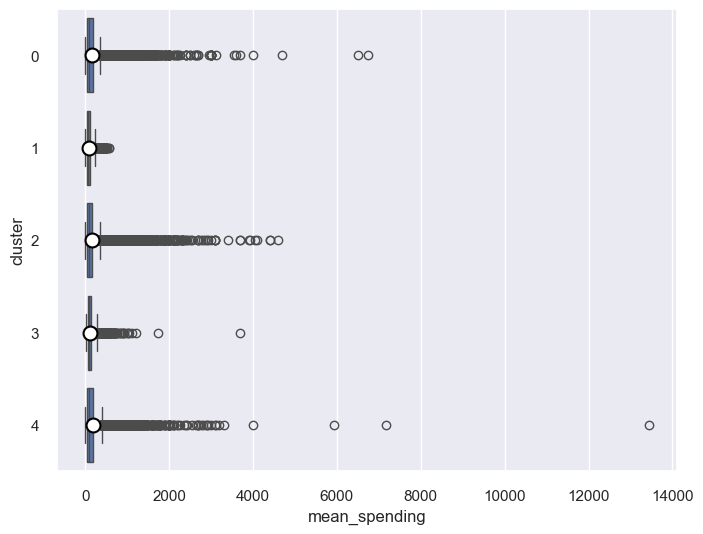

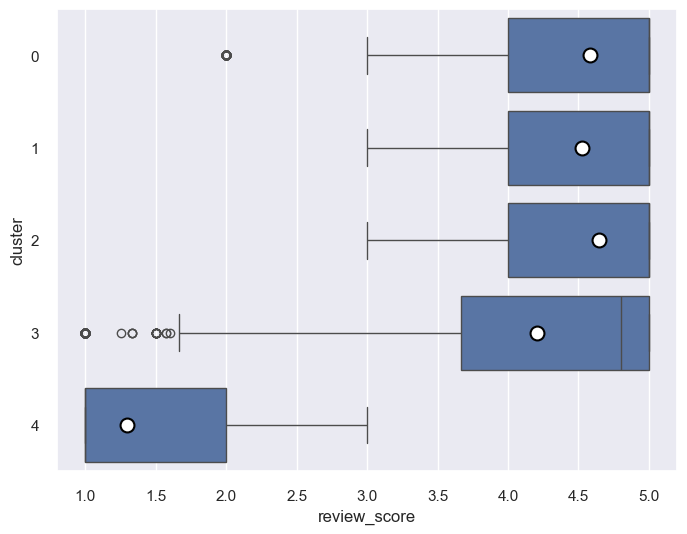

In [82]:
for col in df_rfms.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfms, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

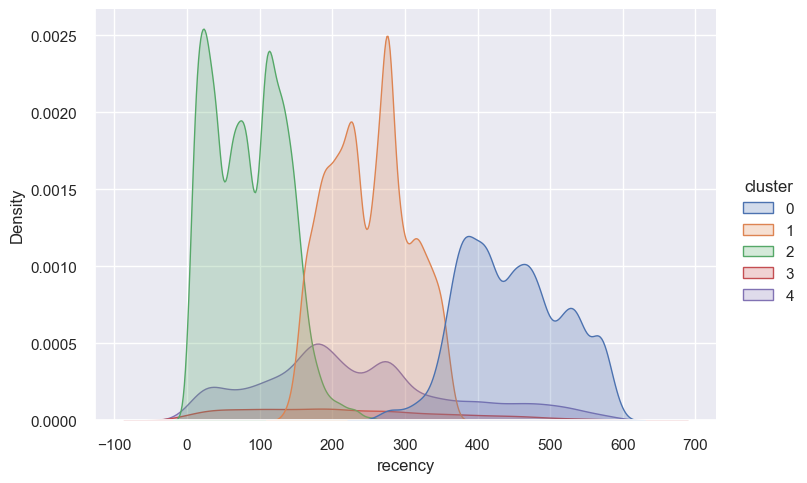

In [83]:
sns.displot(x='recency', data=df_rfms, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

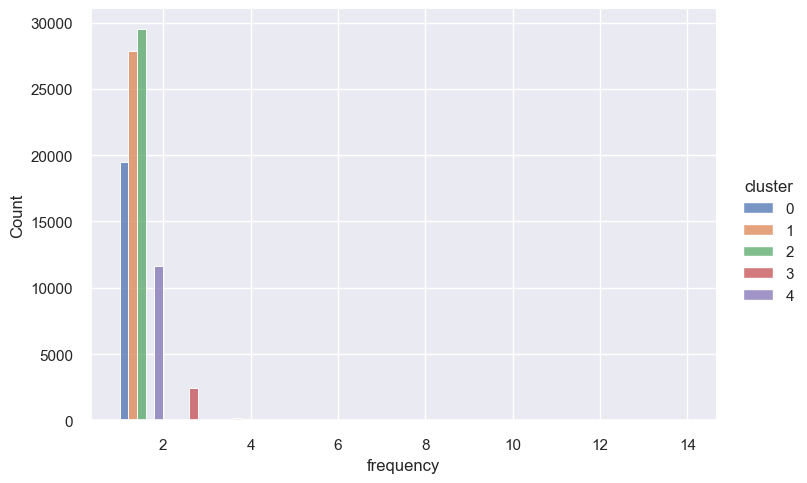

In [152]:
sns.displot(x='frequency', data=df_rfms, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

In [168]:
pd.crosstab(df_rfms['frequency'], df_rfms['cluster'])

cluster        0      1      2     3      4
frequency                                  
1          19475  27863  29543     0  11646
2              0      0      0  2479      0
3              0      0      0   168      0
4              0      0      0    29      0
5              0      0      0     9      0
6              0      0      0     3      0
7              0      0      0     3      0
9              0      0      0     1      0
14             0      0      0     1      0

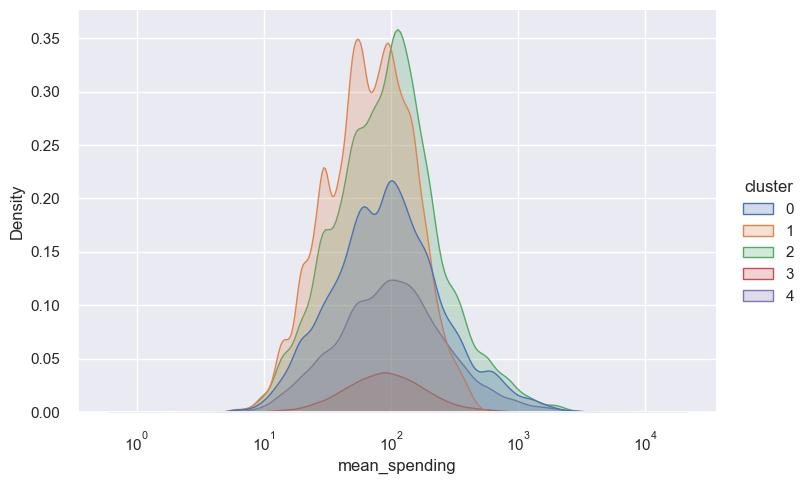

In [85]:
sns.displot(x='mean_spending', data=df_rfms, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5,
           log_scale=True);

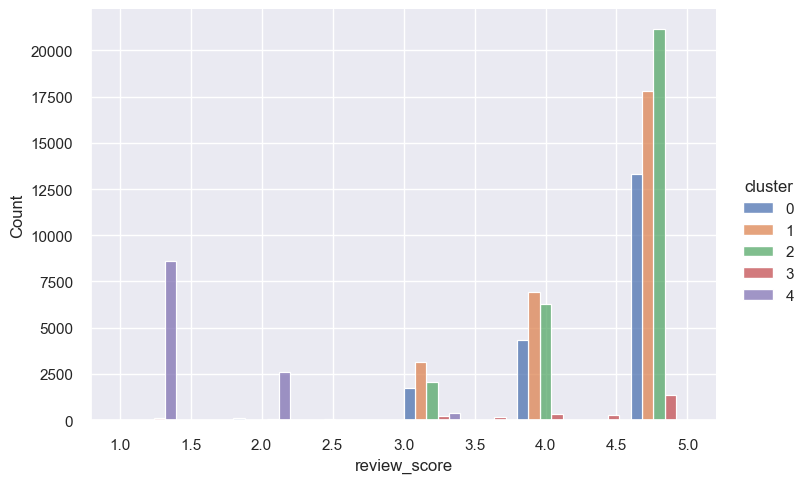

In [148]:
sns.displot(x='review_score', data=df_rfms, hue='cluster', aspect=1.5, palette='deep', multiple='dodge',
           bins=10);

On peut en conclure que :
- Le cluster 0 représente les clients anciens et satisfaits, 
- Le cluster 1 représente les clients récents et satisfaits
- Le cluster 2 représente les clients fréquents, satisfaits ou pas
- Le cluster 3 représente les clients qui dépensent beaucoup,
- Le cluster 4 représente les clients pas ou moyennement satisfaits

Les clients qui dépensent beaucoup (cluster 3) sont également satisfaits pour la plupart (majorité des review_score > 4), ils sont donc les clients les plus intéressants.

# Segmentation RFMST

In [87]:
# Récence - Fréquence - Montant - Score - Total des articles
df_rfmst = pd.read_csv('df_rfmst.csv', index_col=0)
df_rfmst.head()

recency  frequency  mean_spending  \
customer_unique_id                                                    
4b3207464f5f7a48a7f63fa0b1251d86      601          1            9.9   
527cd2850ef91088969ffbef0103dec3      601          1           11.9   
29a63a400c3ca9982907ce8de1f19527      601          1           10.9   
b6b2c3c8fd76769b478618a3c2505009      601          1           10.9   
f7be9bec658c62ab6240b44cd26c0b84      601          2           10.4   

                                  review_score  total_items  
customer_unique_id                                           
4b3207464f5f7a48a7f63fa0b1251d86           5.0            1  
527cd2850ef91088969ffbef0103dec3           5.0            1  
29a63a400c3ca9982907ce8de1f19527           5.0            1  
b6b2c3c8fd76769b478618a3c2505009           5.0            1  
f7be9bec658c62ab6240b44cd26c0b84           5.0            2

## KMeans

In [88]:
from sklearn.cluster import KMeans

In [89]:
# préparation des données pour le clustering
X_rfmst = df_rfmst.copy()

# Centrage et réduction
scaler = StandardScaler()
X_rfmst_scaled = scaler.fit_transform(X_rfmst)
# On remet sous forme de DataFrame
X_rfmst_scaled = pd.DataFrame(X_rfmst_scaled, columns=X_rfmst.columns, index=X_rfmst.index)

### Analyse avec Yellowbrick

In [90]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

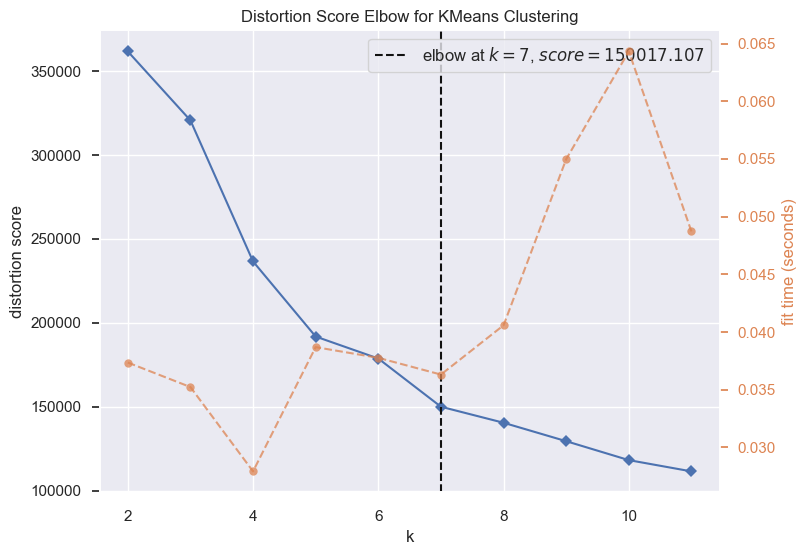

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [91]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
plt.rcParams['figure.figsize'] = (8,6)
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfmst_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

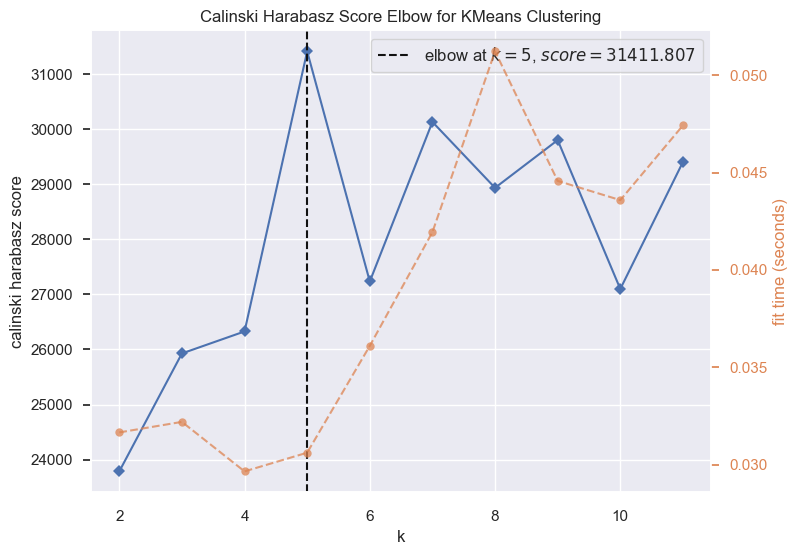

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [92]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfmst_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [93]:
X_rfmst_sample = X_rfmst.sample(10000, random_state=1)
X_rfmst_scaled_sample = scaler.transform(X_rfmst_sample)
# On remet sous forme de DataFrame
X_rfmst_scaled_sample = pd.DataFrame(X_rfmst_scaled_sample, 
                                    index=X_rfmst_sample.index, columns=X_rfmst_sample.columns)

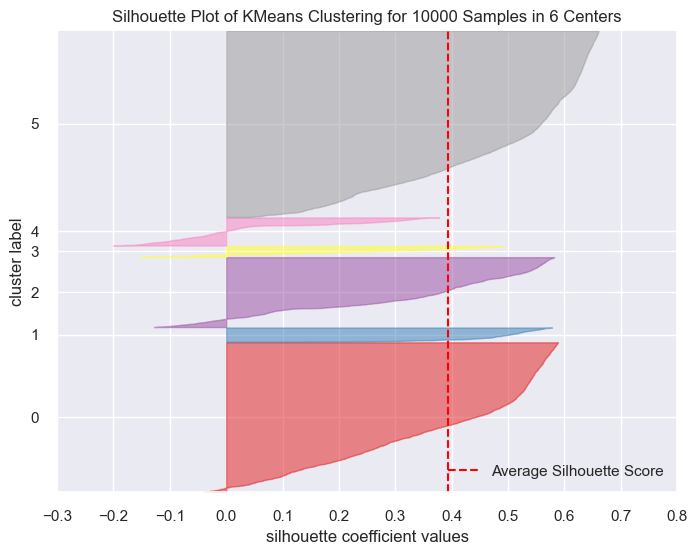

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [94]:
n_clust = 6
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=0)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfmst_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Coefficient de silhouette moyen

In [95]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfmst_scaled_sample, labels, metric='euclidean')

np.float64(0.39269842743598987)

### Clustering

In [96]:
n_clust = 6

# Clustering par K-means
kmeans = KMeans(n_clusters=n_clust, random_state=12)
kmeans.fit(X_rfmst_scaled)

# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [97]:
# Nombre de clients par cluster
pd.Series(clusters).value_counts()

1    40361
0    30886
5    15007
4     2706
2     1977
3      283
Name: count, dtype: int64

### Visualisations

#### Visualisation dans l'espace des variables

In [98]:
import itertools

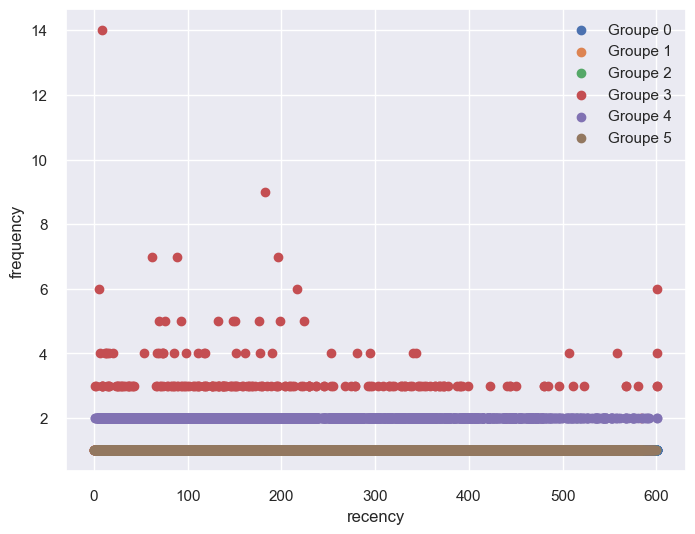

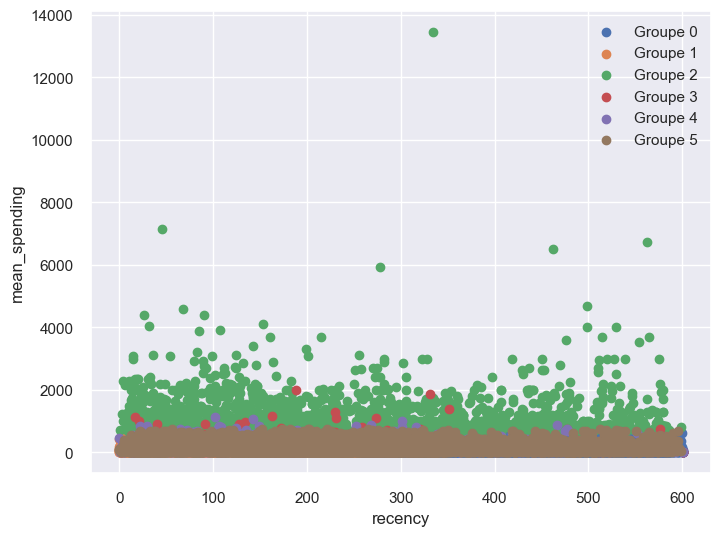

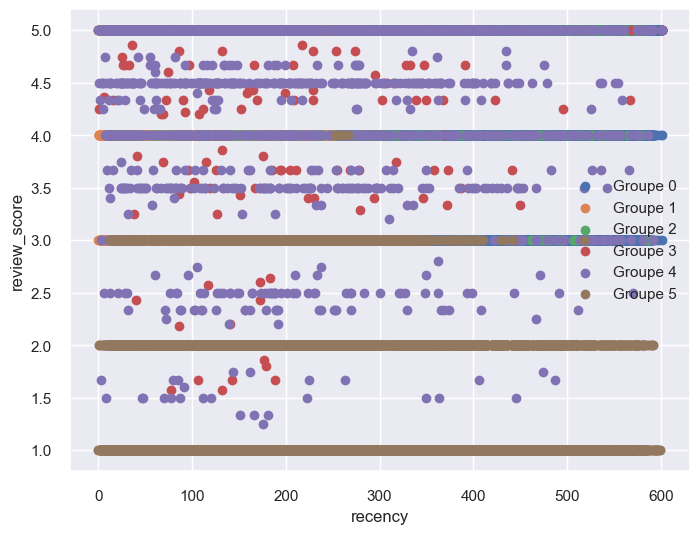

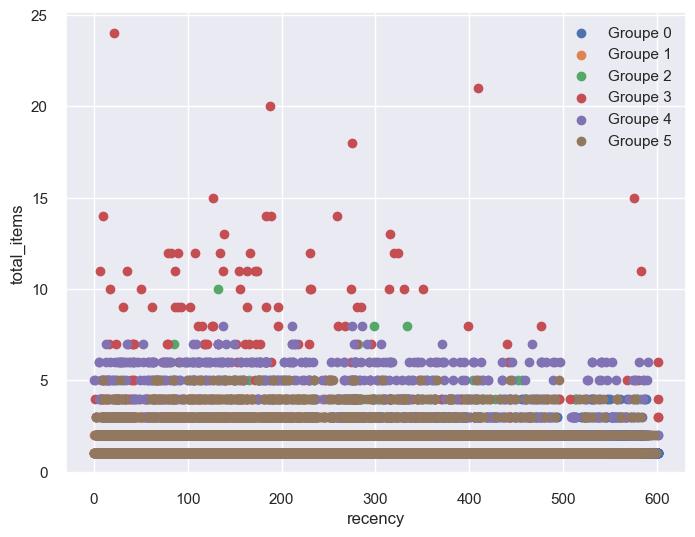

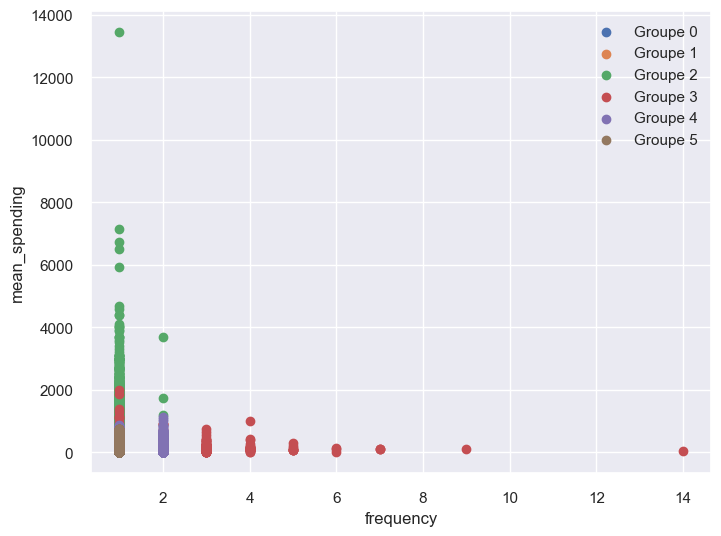

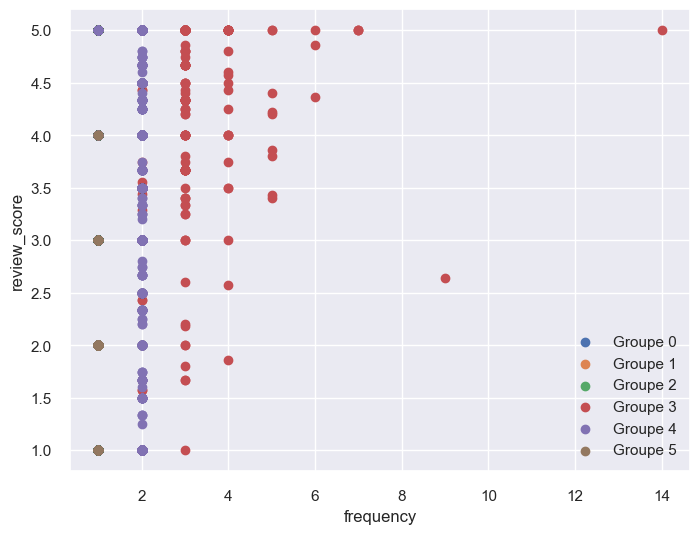

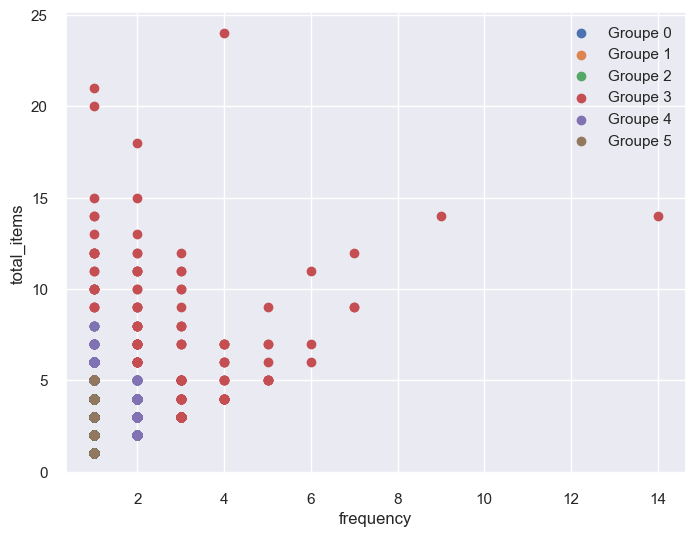

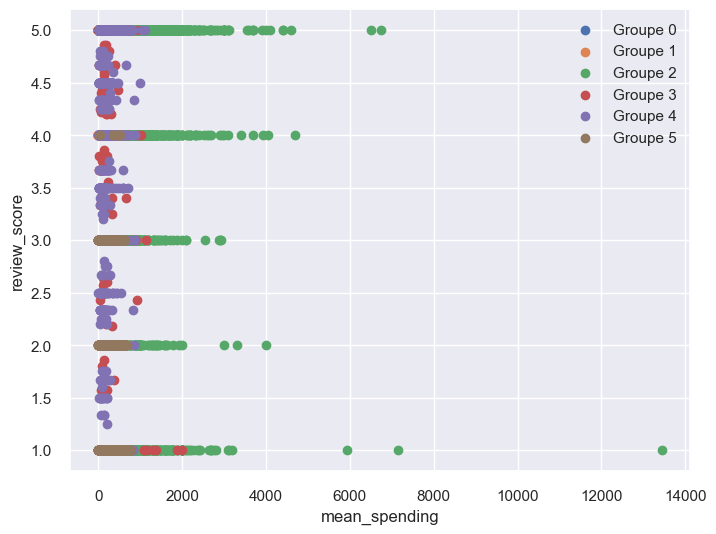

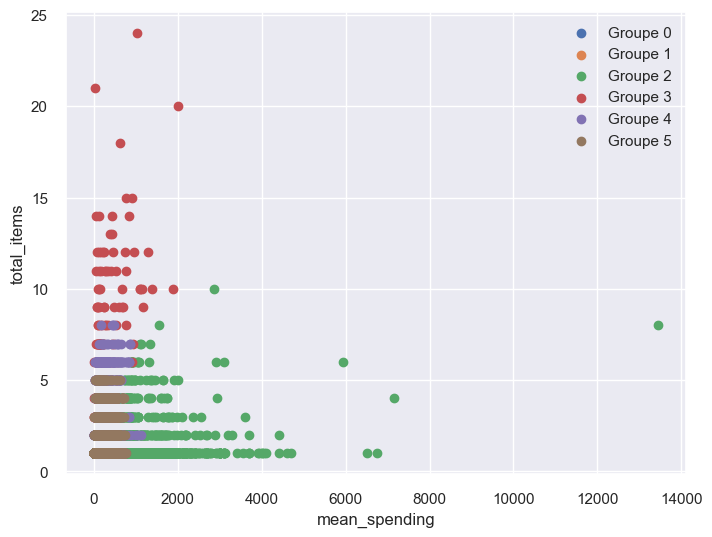

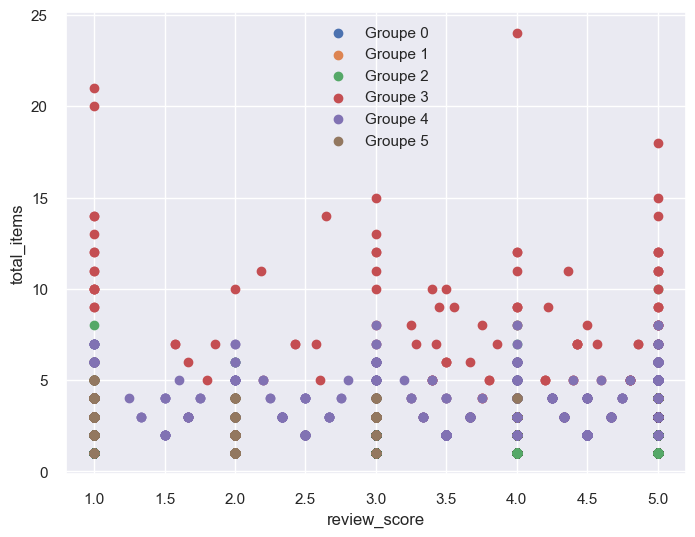

In [99]:
for (i, j) in itertools.combinations(range(X_rfmst.shape[1]), 2):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfmst.iloc[mask, i], X_rfmst.iloc[mask, j], label='Groupe {}'.format(cluster))
    #plt.xticks(rotation=30)
    plt.xlabel(X_rfmst.columns[i])
    plt.ylabel(X_rfmst.columns[j])
    plt.legend();

#### Box plots

In [100]:
df_rfmst['cluster'] = clusters

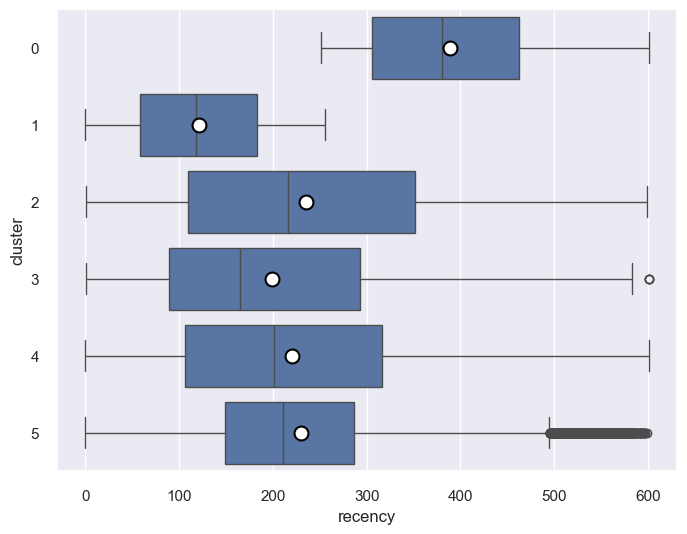

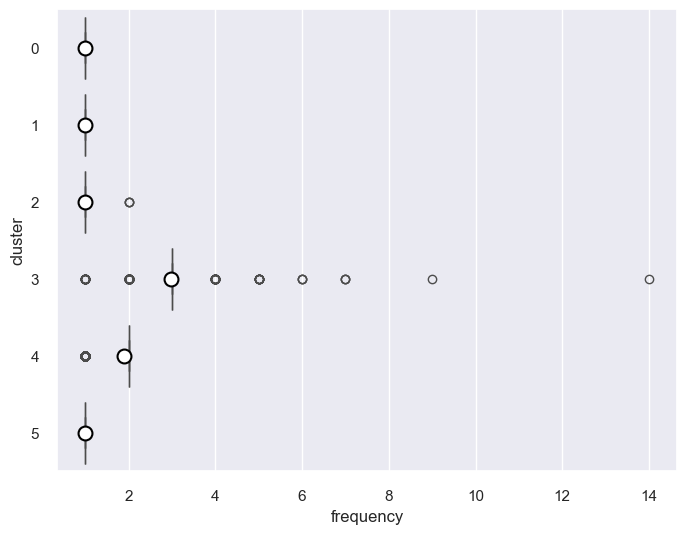

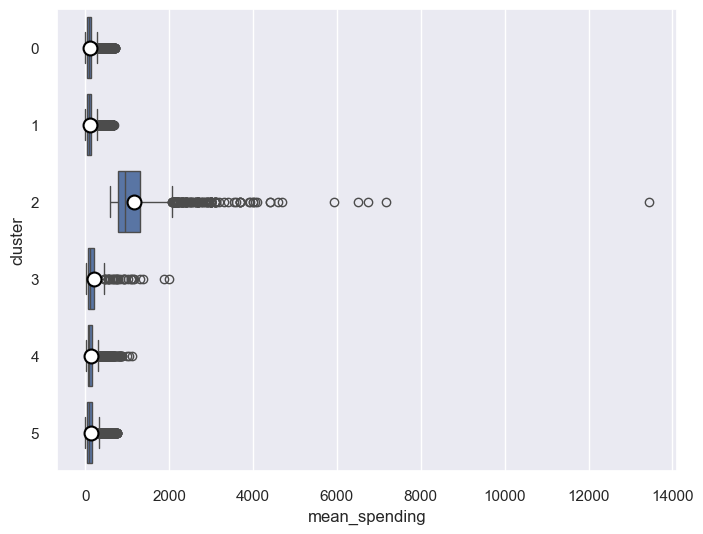

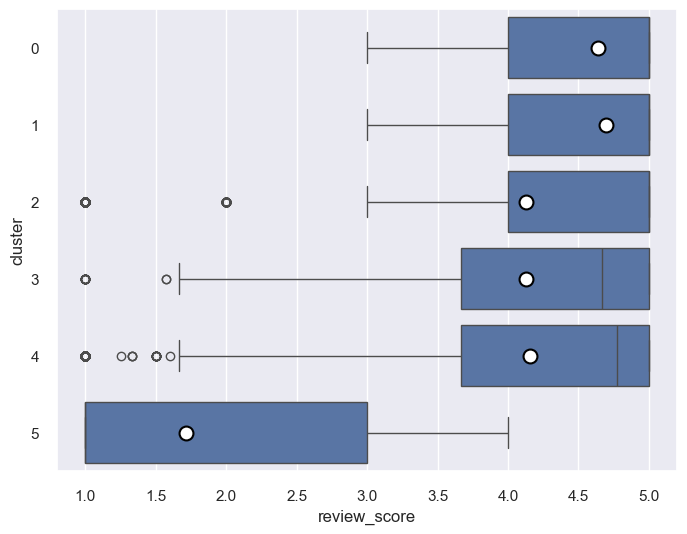

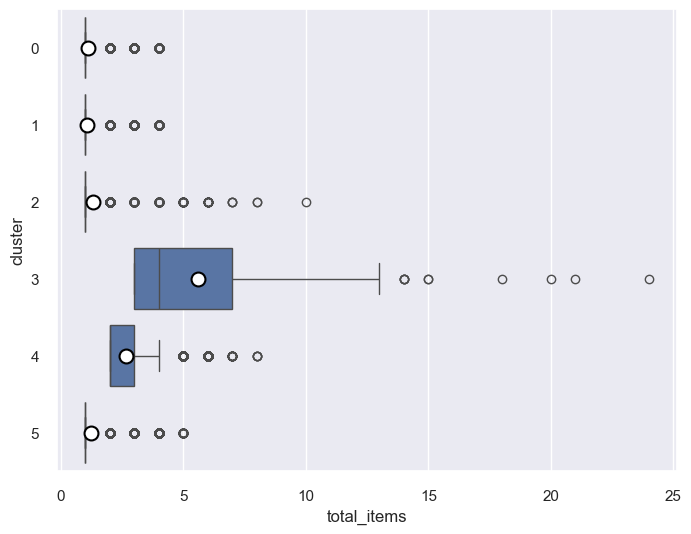

In [101]:
for col in df_rfmst.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfmst, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

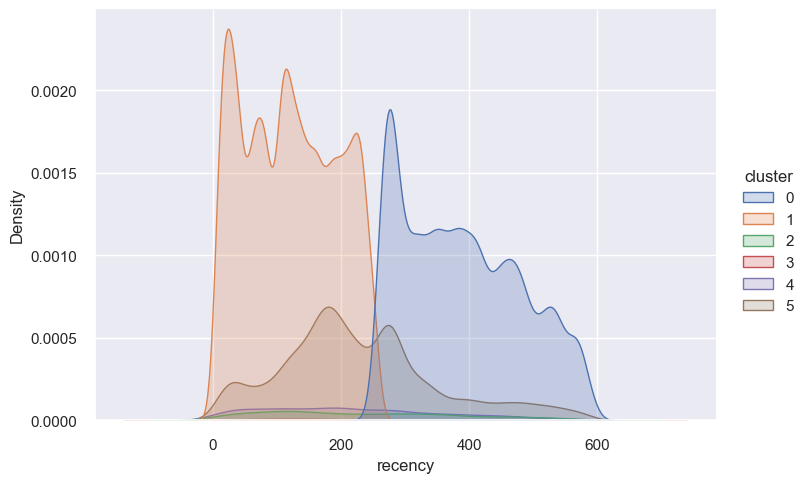

In [102]:
sns.displot(x='recency', data=df_rfmst, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

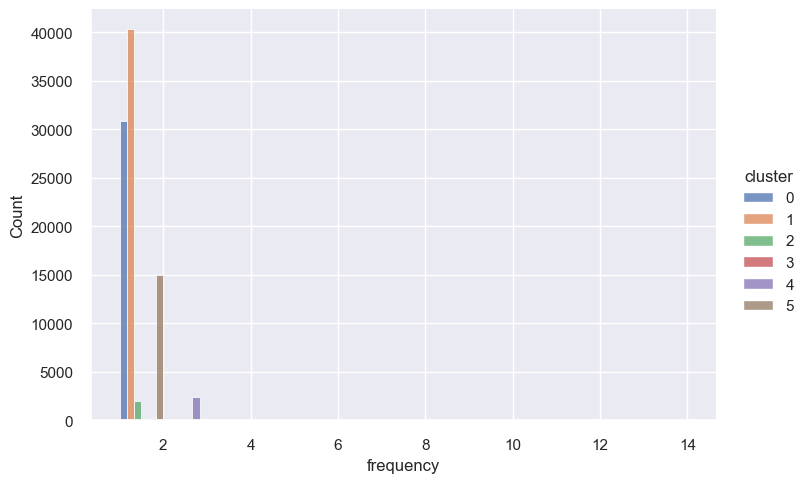

In [146]:
sns.displot(x='frequency', data=df_rfmst, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

In [159]:
pd.crosstab(df_rfmst['frequency'], df_rfmst['cluster'])

cluster        0      1     2    3     4      5
frequency                                      
1          30886  40361  1974   21   278  15007
2              0      0     3   48  2428      0
3              0      0     0  168     0      0
4              0      0     0   29     0      0
5              0      0     0    9     0      0
6              0      0     0    3     0      0
7              0      0     0    3     0      0
9              0      0     0    1     0      0
14             0      0     0    1     0      0

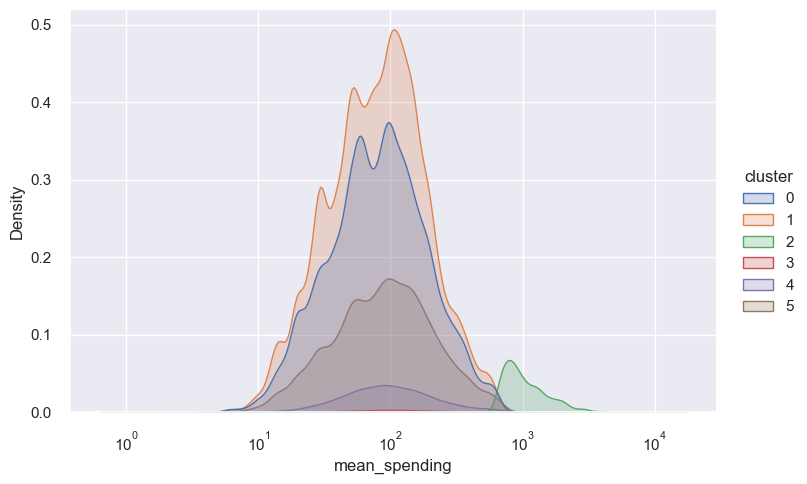

In [104]:
sns.displot(x='mean_spending', data=df_rfmst, hue='cluster', kind='kde', fill=True, 
            palette='deep', aspect=1.5, log_scale=True);

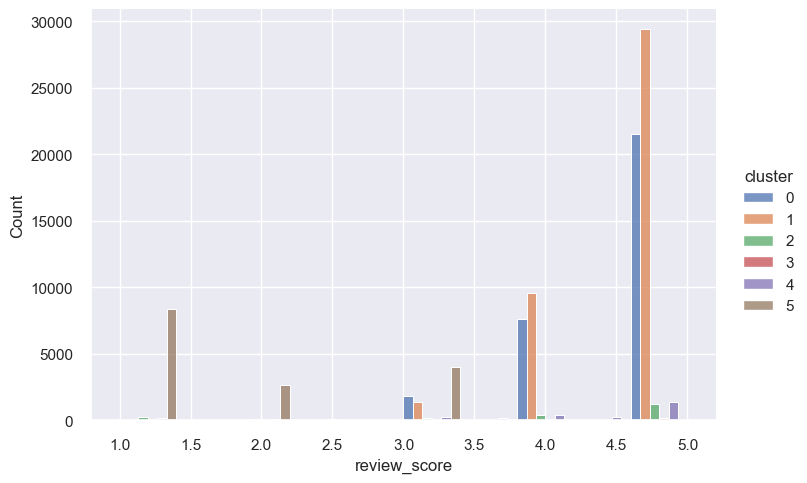

In [140]:
sns.displot(x='review_score', data=df_rfmst, hue='cluster', aspect=1.5, palette='deep', multiple='dodge',
           bins=10);

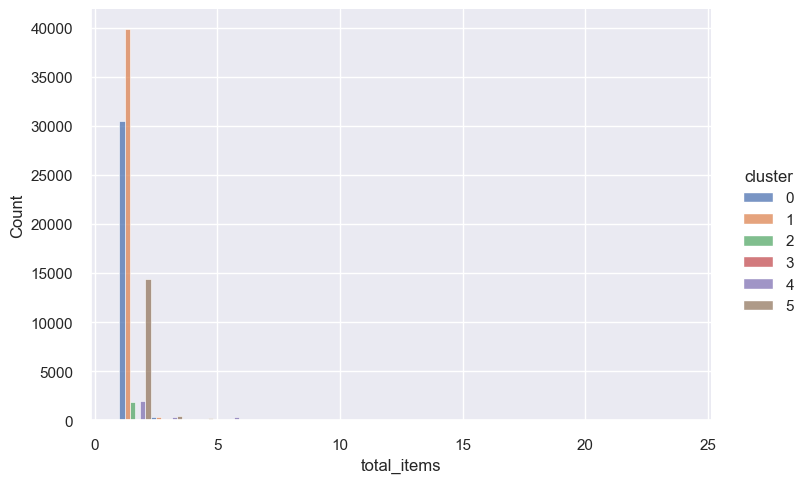

In [142]:
sns.displot(x='total_items', data=df_rfmst, hue='cluster', aspect=1.5, palette='deep', multiple='dodge');

In [162]:
pd.crosstab(df_rfmst['total_items'], df_rfmst['cluster'])

cluster          0      1     2    3     4      5
total_items                                      
1            28499  37558  1673    0     0  12234
2             1989   2353   148    0  1908   2144
3              299    344    60  109   353    424
4               99    106    48   42   131    173
5                0      0    26   31   150     32
6                0      0    16   19   143      0
7                0      0     3   23    17      0
8                0      0     2    9     4      0
9                0      0     0   11     0      0
10               0      0     1    9     0      0
11               0      0     0    9     0      0
12               0      0     0    9     0      0
13               0      0     0    2     0      0
14               0      0     0    4     0      0
15               0      0     0    2     0      0
18               0      0     0    1     0      0
20               0      0     0    1     0      0
21               0      0     0    1     0      0
24               0      0     0    1     0      0

Les clients fréquents et ceux ayant acheté beaucoup d'articles sont mélangés dans deux clusters différents

# Segmentation RFMSA

In [107]:
# Récence - Fréquence - Montant - Score - Articles par commande
df_rfmsa = pd.read_csv('df_rfmsa.csv', index_col=0)
df_rfmsa.head()

recency  frequency  mean_spending  \
customer_unique_id                                                    
4b3207464f5f7a48a7f63fa0b1251d86      601          1            9.9   
527cd2850ef91088969ffbef0103dec3      601          1           11.9   
29a63a400c3ca9982907ce8de1f19527      601          1           10.9   
b6b2c3c8fd76769b478618a3c2505009      601          1           10.9   
f7be9bec658c62ab6240b44cd26c0b84      601          2           10.4   

                                  review_score  items_per_order  
customer_unique_id                                               
4b3207464f5f7a48a7f63fa0b1251d86           5.0                1  
527cd2850ef91088969ffbef0103dec3           5.0                1  
29a63a400c3ca9982907ce8de1f19527           5.0                1  
b6b2c3c8fd76769b478618a3c2505009           5.0                1  
f7be9bec658c62ab6240b44cd26c0b84           5.0                1

## KMeans

In [108]:
from sklearn.cluster import KMeans

In [109]:
# préparation des données pour le clustering
X_rfmsa = df_rfmsa.copy()

# Centrage et réduction
scaler = StandardScaler()
X_rfmsa_scaled = scaler.fit_transform(X_rfmsa)
# On remet sous forme de DataFrame
X_rfmsa_scaled = pd.DataFrame(X_rfmsa_scaled, columns=X_rfmsa.columns, index=X_rfmsa.index)

### Analyse avec Yellowbrick

In [110]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

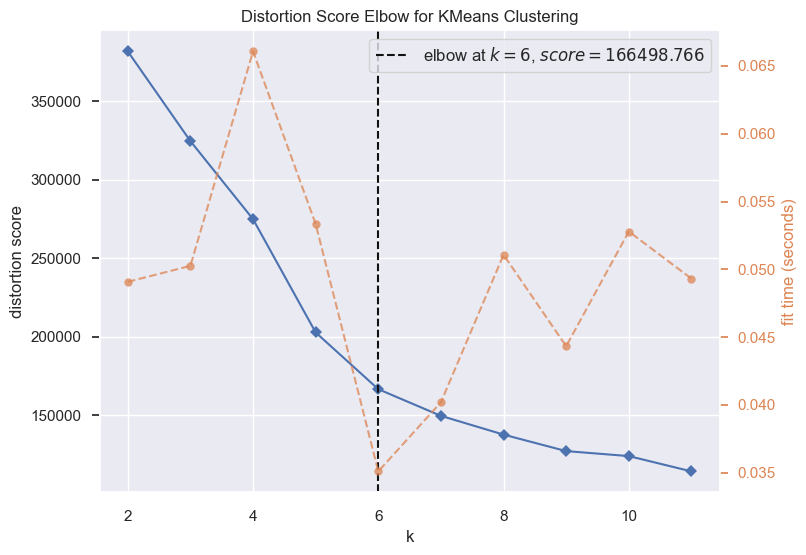

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [111]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
plt.rcParams['figure.figsize'] = (8,6)
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfmsa_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

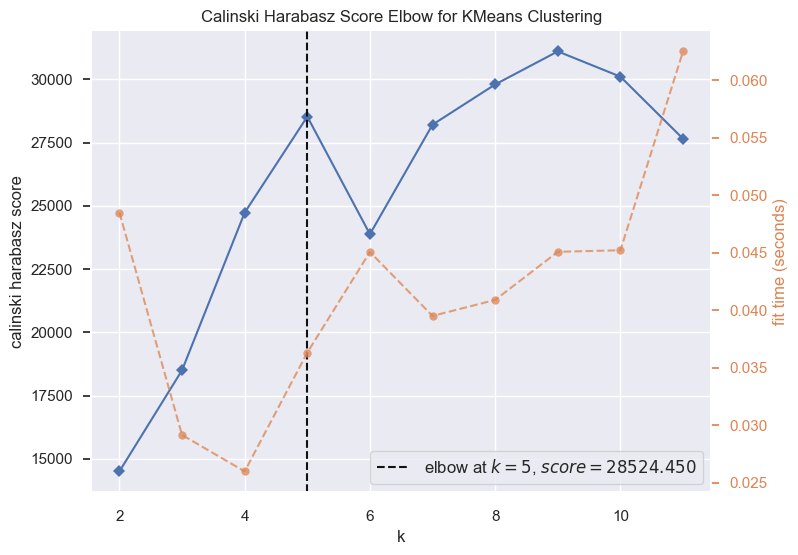

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [112]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfmsa_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [113]:
X_rfmsa_sample = X_rfmsa.sample(10000, random_state=1)
X_rfmsa_scaled_sample = scaler.transform(X_rfmsa_sample)
# On remet sous forme de DataFrame
X_rfmsa_scaled_sample = pd.DataFrame(X_rfmsa_scaled_sample, 
                                    index=X_rfmsa_sample.index, columns=X_rfmsa_sample.columns)

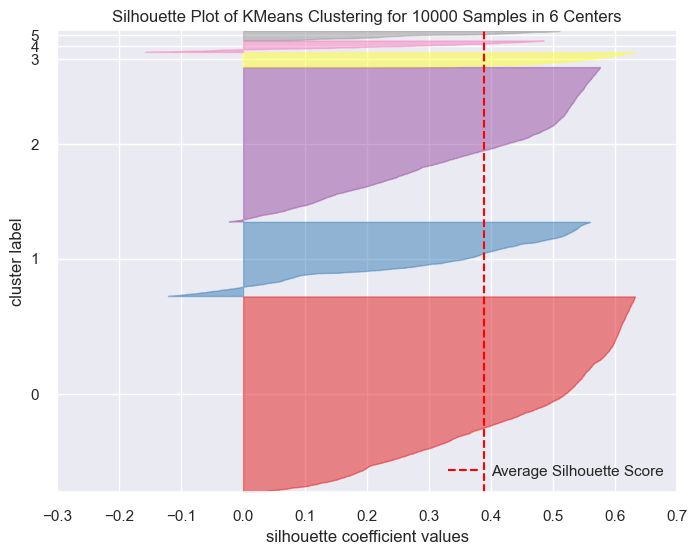

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [114]:
n_clust = 6
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=0)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfmsa_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Coefficient de silhouette moyen

In [115]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfmsa_scaled_sample, labels, metric='euclidean')

np.float64(0.3891913882975755)

### Clustering

In [116]:
n_clust = 6

# Clustering par K-means
kmeans = KMeans(n_clusters=n_clust, random_state=12)
kmeans.fit(X_rfmsa_scaled)

# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [117]:
# Nombre de clients par cluster
pd.Series(clusters).value_counts()

2    39999
0    30697
1    14857
3     2995
5     2458
4      214
Name: count, dtype: int64

### Visualisations

#### Box plots

In [118]:
df_rfmsa['cluster'] = clusters

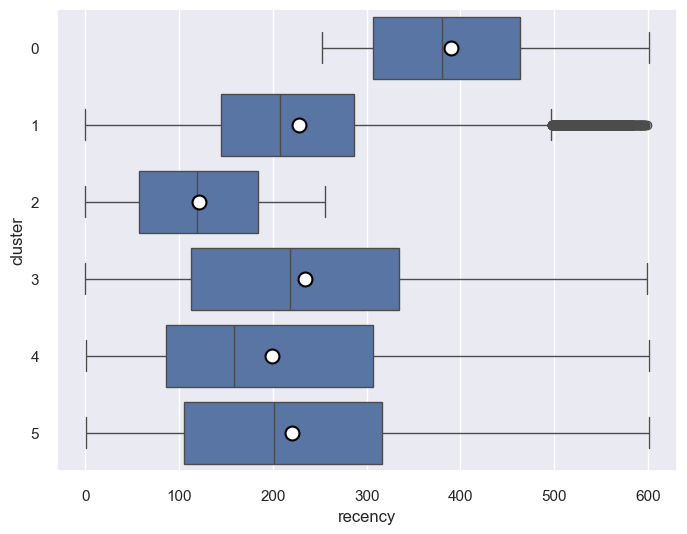

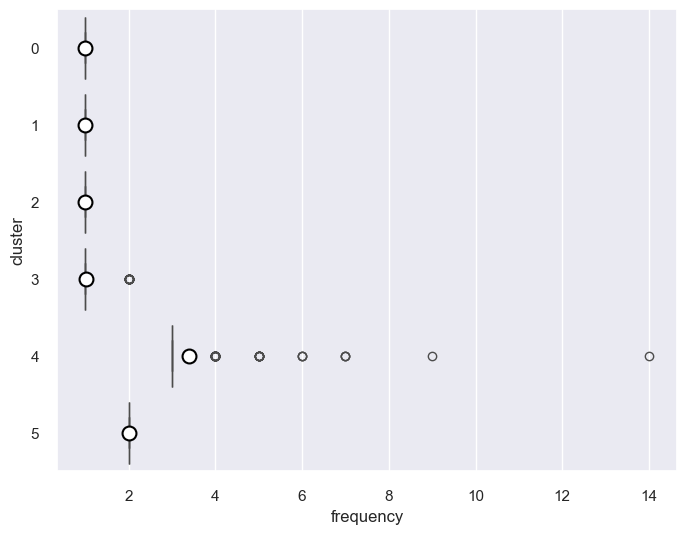

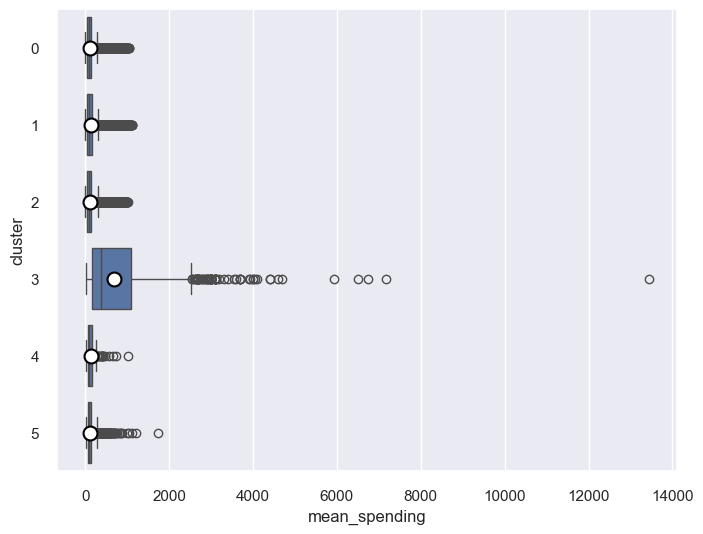

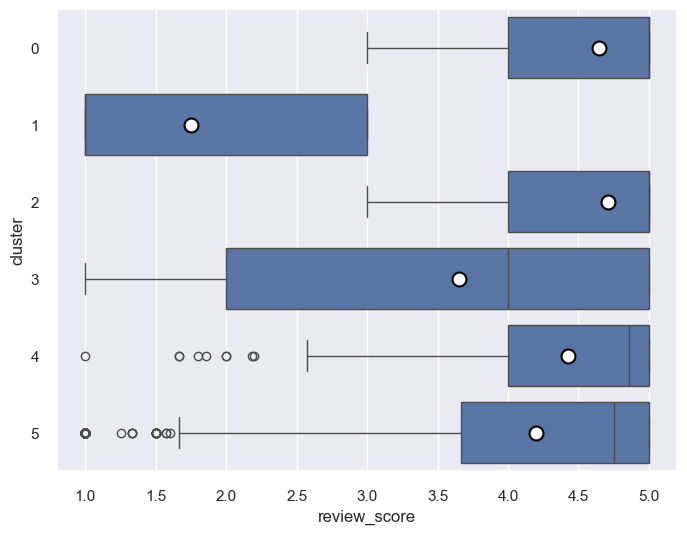

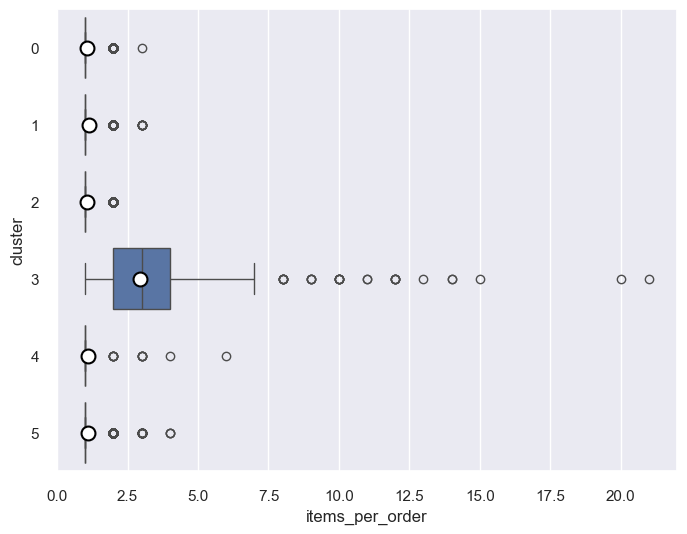

In [119]:
for col in df_rfmsa.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfmsa, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

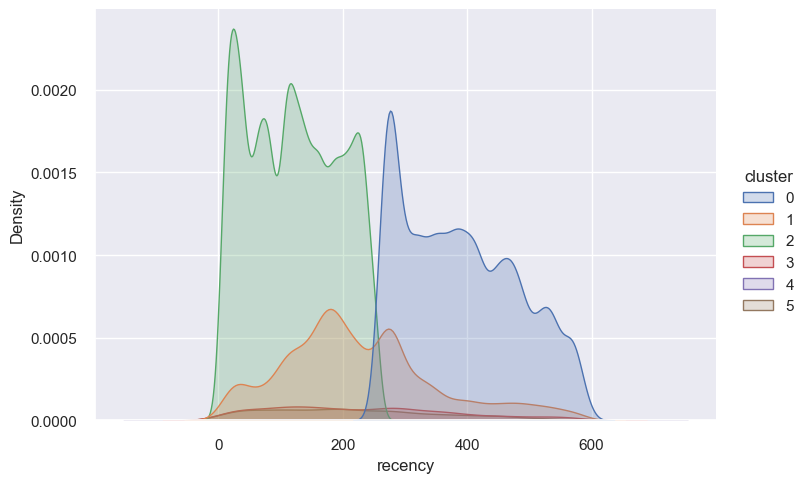

In [120]:
sns.displot(x='recency', data=df_rfmsa, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

In [157]:
pd.crosstab(df_rfmsa['frequency'], df_rfmsa['cluster'])

cluster        0      1      2     3    4     5
frequency                                      
1          30697  14857  39999  2974    0     0
2              0      0      0    21    0  2458
3              0      0      0     0  168     0
4              0      0      0     0   29     0
5              0      0      0     0    9     0
6              0      0      0     0    3     0
7              0      0      0     0    3     0
9              0      0      0     0    1     0
14             0      0      0     0    1     0

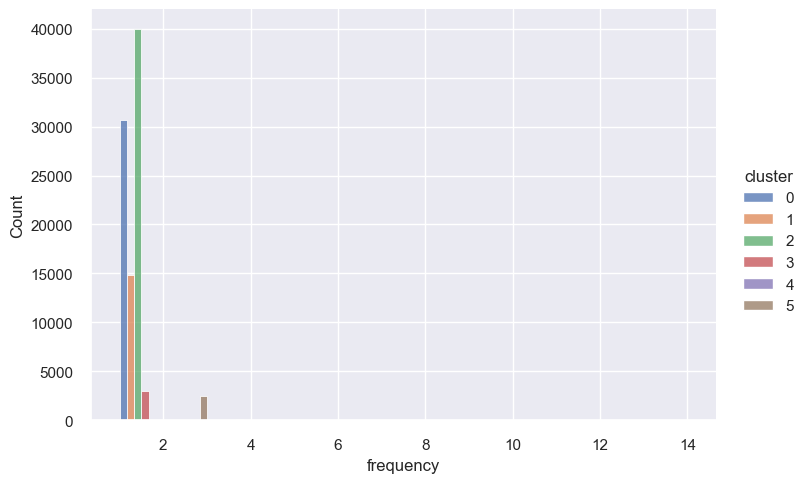

In [139]:
sns.displot(x='frequency', data=df_rfmsa, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

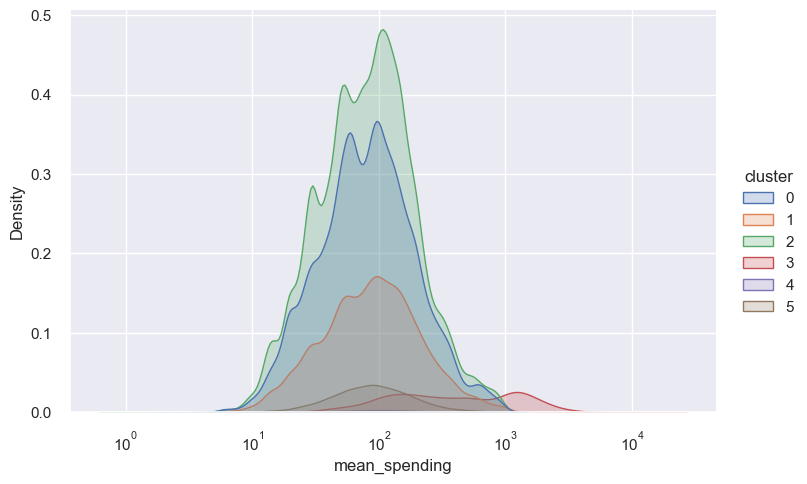

In [122]:
sns.displot(x='mean_spending', data=df_rfmsa, hue='cluster', kind='kde', fill=True, palette='deep', 
            aspect=1.5, log_scale=True);

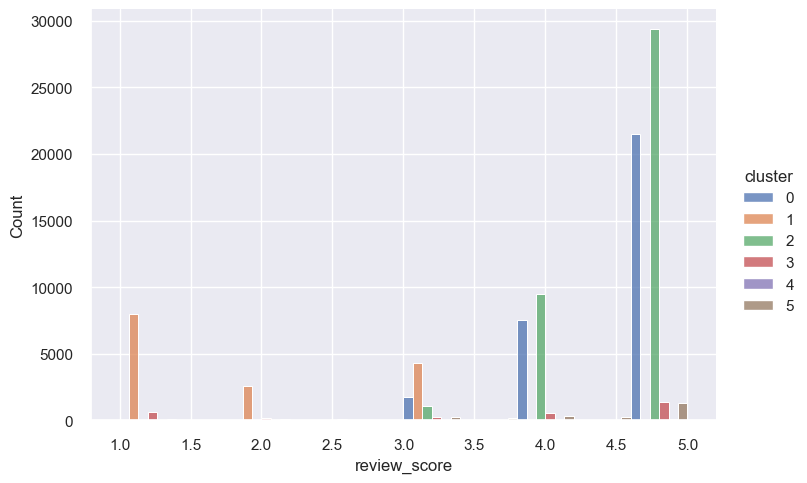

In [123]:
sns.displot(x='review_score', data=df_rfmsa, hue='cluster', aspect=1.5, palette='deep', multiple='dodge',
           bins=10);

In [165]:
pd.crosstab(df_rfmsa['items_per_order'], df_rfmsa['cluster'])

cluster              0      1      2     3    4     5
items_per_order                                      
1                28765  12762  37696   742  201  2263
2                 1931   2086   2303   311    6   167
3                    1      9      0  1119    5    25
4                    0      0      0   433    1     3
5                    0      0      0   178    0     0
6                    0      0      0   162    1     0
7                    0      0      0    21    0     0
8                    0      0      0     6    0     0
9                    0      0      0     4    0     0
10                   0      0      0     6    0     0
11                   0      0      0     2    0     0
12                   0      0      0     5    0     0
13                   0      0      0     1    0     0
14                   0      0      0     2    0     0
15                   0      0      0     1    0     0
20                   0      0      0     1    0     0
21                   0      0      0     1    0     0

Cette fois la segmentation semble meilleure que lorsqu'on prend le total des articles. On peut notamment voir que :
- Le cluster 0 représente les clients récents
- Le cluster 1 représente les clients anciens
- Le cluster 2 représente les clients ayant commandé beaucoup d'articles en moyenne
- Le cluster 3 représente les clients insatisfaits
- Le cluster 4 représente les clients qui dépensent beaucoup
- Le cluster 5 représente les clients fréquents